<a href="https://colab.research.google.com/github/chuancao26/islp/blob/main/nonLinearExercices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 2.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=95055fee2cd19203a77c6b6fcf847c9e3b9c1e0c20656d14876411b9200bb421
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [32]:
# algunos imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         poly,
                         summarize,
                         bs,
                         ns,
                         sklearn_selected,
                         Stepwise,
                         sklearn_selection_path)
from ISLP.pygam import (plot as plot_gam,
                        anova as anova_gam,
                        approx_lam,
                        degrees_of_freedom)
from ISLP.transforms import NaturalSpline, BSpline

import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (PolynomialFeatures,
                                   KBinsDiscretizer,
                                   StandardScaler,
                                   SplineTransformer)
from sklearn.compose import ColumnTransformer

from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)


# Applied

## 1

In [ ]:
wage = load_data("Wage")
age = wage["age"]

In [ ]:
wage.describe()

year          age      logwage         wage
count  3000.000000  3000.000000  3000.000000  3000.000000
mean   2005.791000    42.414667     4.653905   111.703608
std       2.026167    11.542406     0.351753    41.728595
min    2003.000000    18.000000     3.000000    20.085537
25%    2004.000000    33.750000     4.447158    85.383940
50%    2006.000000    42.000000     4.653213   104.921507
75%    2008.000000    51.000000     4.857332   128.680488
max    2009.000000    80.000000     5.763128   318.342430

In [ ]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        3000 non-null   int64   
 1   age         3000 non-null   int64   
 2   maritl      3000 non-null   category
 3   race        3000 non-null   category
 4   education   3000 non-null   category
 5   region      3000 non-null   category
 6   jobclass    3000 non-null   category
 7   health      3000 non-null   category
 8   health_ins  3000 non-null   category
 9   logwage     3000 non-null   float64 
 10  wage        3000 non-null   float64 
dtypes: category(7), float64(2), int64(2)
memory usage: 115.5 KB


### a

vamos a hacer la regresion polinomial usando age para explicacar Wage
Necesitamos algunas cosas.
- especificar el kfold
- matriz de features
- algoritmo de regresion

#### Regresion Polinomial

In [ ]:
design = MS([poly("age", degree=8)]).fit(wage)

X = design.transform(wage)
y = wage["wage"]

model = sm.OLS(y, X).fit()
summarize(model)


coef  std err        t  P>|t|
intercept               111.7036    0.729  153.308  0.000
poly(age, degree=8)[0]  447.0679   39.908   11.202  0.000
poly(age, degree=8)[1] -478.3158   39.908  -11.985  0.000
poly(age, degree=8)[2]  125.5217   39.908    3.145  0.002
poly(age, degree=8)[3]  -77.9112   39.908   -1.952  0.051
poly(age, degree=8)[4]  -35.8129   39.908   -0.897  0.370
poly(age, degree=8)[5]   62.7077   39.908    1.571  0.116
poly(age, degree=8)[6]   50.5498   39.908    1.267  0.205
poly(age, degree=8)[7]  -11.2547   39.908   -0.282  0.778

vamos a graficar la funcion estimada

Text(0, 0.5, 'wage')

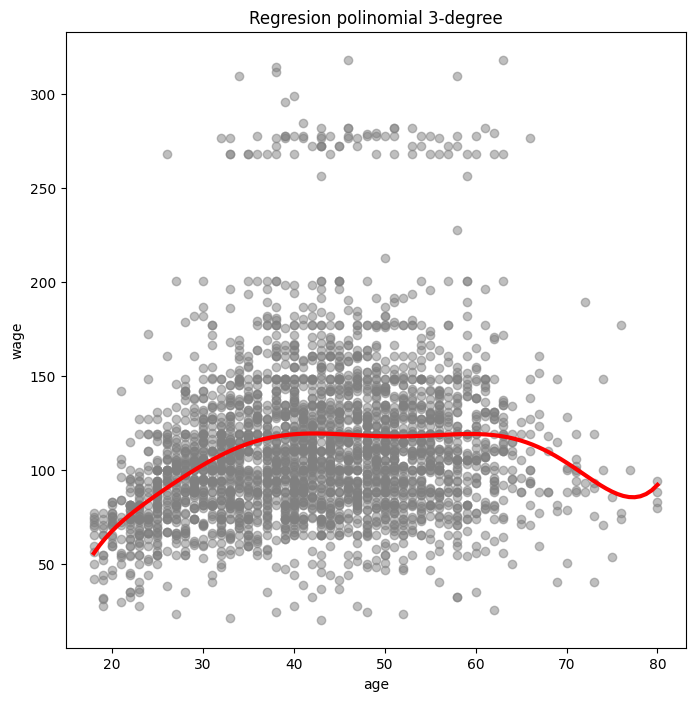

In [ ]:
age_grid = np.linspace(wage["age"].min(),
                      wage["age"].max(),
                      100)
predicted = model.predict(design.transform(pd.DataFrame({"age": age_grid})))
fig, ax = plt.subplots(figsize=(8,8))
# Grafico de los puntos
ax.scatter(age, y,
           alpha=.5,
           facecolor="gray");
# Grafico de la funcion de regresion
ax.plot(age_grid, predicted,
        color="red",
        linewidth=3)
ax.set_title("Regresion polinomial 3-degree")
ax.set_xlabel("age")
ax.set_ylabel("wage")


Vamos a validar los resultados con cross validation con k = 10

In [ ]:
k = 10
kfold = skm.KFold(k,
              shuffle=True,
              random_state=2)
results = skm.cross_val_score(skl.LinearRegression(),
                              X,
                              y,
                              scoring="neg_mean_squared_error",
                              cv=kfold)
print(f"Simple Polinomial regression 3-d con un score de: {np.mean(-results)}")

Simple Polinomial regression 3-d con un score de: 1596.5930103094584


#### Wise Selection of d

Ahora vamos a buscar el mejor modelo con diferentes valores para d:


In [ ]:
degrees = np.arange(1, 10 + 1)
mse = np.zeros(10)
kfold = skm.KFold(5,
              shuffle=True,
              random_state=2)
for d in degrees:

  design = MS([poly("age", degree=d)])

  pipe = Pipeline([("design", design),
                  ("model", skl.LinearRegression())])

  results = skm.cross_validate(pipe,
                              wage,
                              wage["wage"],
                              scoring="neg_mean_squared_error",
                               cv=kfold)

  mse[d-1] = np.mean(-results["test_score"])

In [ ]:
mse

array([1675.07800104, 1599.71568141, 1594.7607508 , 1593.39352217,
       1593.42232694, 1592.99793417, 1592.94603594, 1593.69403581,
       1592.67457781, 1594.21194103])

Text(0, 0.5, 'MSE')

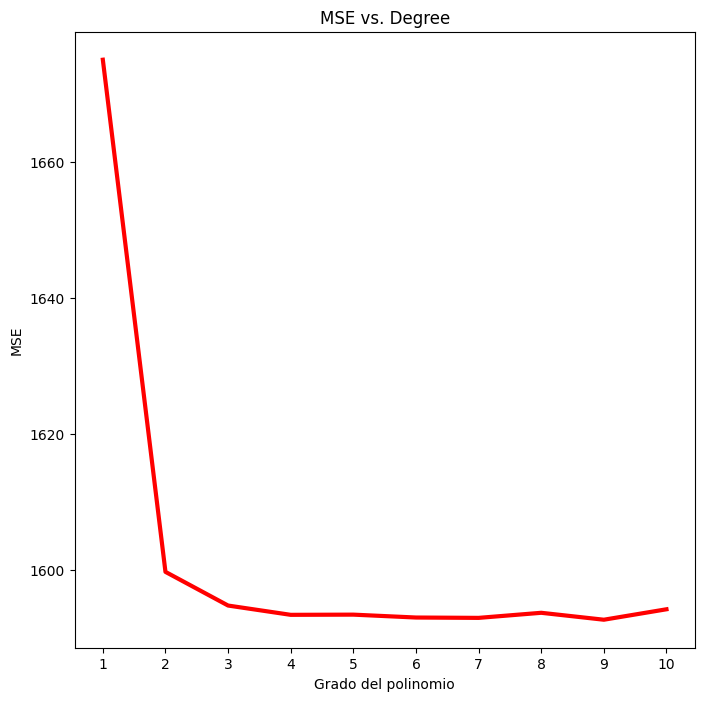

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(degrees, mse,
        linewidth=3,
        color="red")
ax.set_xticks(degrees)
ax.set_title("MSE vs. Degree")
ax.set_xlabel("Grado del polinomio")
ax.set_ylabel("MSE")

Podemos apreciar una caida mas que evidente con un modelo con 3 a 4 grados en el polinomio


In [ ]:
# graficamos el modelo con 4-degree
kfold = skm.KFold(10,
              shuffle=True,
              random_state=2)
design = MS([poly("age", degree=4)])

pipe = Pipeline([("design", design),
                ("model", skl.LinearRegression())])

results = skm.cross_validate(pipe,
                             wage,
                             wage["wage"],
                             scoring="neg_mean_squared_error",
                             cv=kfold)
print(f"Simple Polinomial regression 4-d con un score de: {np.mean(-results['test_score'])}")

Simple Polinomial regression 4-d con un score de: 1595.0572027232408


Veamos el analisis ANOVA con modelos polinomiales con d tomando valores de 1 a 6

In [ ]:
models = []
for d in range(1, 6 + 1):
  design = MS([poly("age", degree=d)])
  X = design.fit_transform(wage)

  model = sm.OLS(wage["wage"], X).fit()
  models.append(model)

In [ ]:
print(anova_lm(*models))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.663571  2.285169e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.893609  1.674794e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.811683  5.098933e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.805371  3.695646e-01
5    2993.0  4.766389e+06      1.0    3932.257665    2.469216  1.162015e-01


Con estos resultados, podemos decir que el valor p es significativo hasta un modelo  con d = 4 sin embargo el modelo con d=3 es mejor ya que el cambio no es tan significativo.

##### GridSearch

In [ ]:
age = wage["age"]
y = wage["wage"]

k=5
kfold = skm.KFold(k,
                  shuffle=True,
                  random_state=1)
params_grid = {"poly__degree": np.arange(1, 20)}

pipe = Pipeline([("poly", PolynomialFeatures()),
                 ("model", skl.LinearRegression())])

cv_grid = skm.GridSearchCV(pipe,
                           param_grid=params_grid,
                           cv=kfold,
                           scoring="neg_mean_squared_error").fit(np.reshape(age, (-1,1)),
                                         y)
cv_grid


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('model', LinearRegression())]),
             param_grid={'poly__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='neg_mean_squared_error')

In [ ]:
best_degree = cv_grid.best_params_["poly__degree"]
best_degree


np.int64(8)

In [ ]:
pipe = Pipeline([("poly", PolynomialFeatures(degree=8)),
                  ("linreg", skl.LinearRegression())])

results = skm.cross_validate(pipe,
                             np.reshape(wage["age"], (-1,1)),
                             wage["wage"],
                             scoring="neg_mean_squared_error",
                             cv=kfold)
np.mean(-results["test_score"])
#

np.float64(1592.1024401205923)

In [ ]:
pipe.fit(np.reshape(wage["age"], (-1,1)), wage["wage"])

Pipeline(steps=[('poly', PolynomialFeatures(degree=8)),
                ('linreg', LinearRegression())])

In [ ]:
# hagamos el analisis ANOVA
designs = [MS([poly("age", degree=i)]) for i in range(1, best_degree + 1)]
models = [sm.OLS(wage["wage"], design.fit_transform(wage)).fit() for design in designs]
print(anova_lm(*models))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.648400  2.301885e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.892564  1.675742e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.811280  5.100157e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.805286  3.695898e-01
5    2993.0  4.766389e+06      1.0    3932.257665    2.468956  1.162208e-01
6    2992.0  4.763834e+06      1.0    2555.281281    1.604390  2.053807e-01
7    2991.0  4.763707e+06      1.0     126.668985    0.079532  7.779522e-01


Text(0.5, 1.0, 'Regresion polinomial 8-degree')

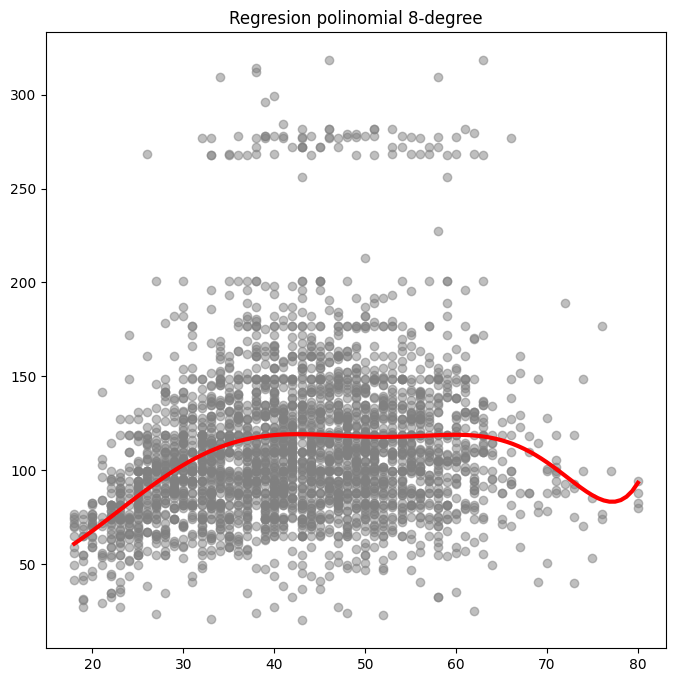

In [ ]:
# Vamos a graficar el modelo mas optimo (d = 8)
age_grid = np.linspace(wage["age"].min(),
                      wage["age"].max(),
                      100)
fig, ax = plt.subplots(figsize=(8,8))
# Grafico de los puntos
ax.scatter(age, y, facecolor="gray", alpha=.5)
# Graficando la funcion estimada
ax.plot(age_grid, pipe.predict(np.reshape(age_grid, (-1 ,1))),
        color="red",
        linewidth=3)
ax.set_title("Regresion polinomial 8-degree")

#### b con el uso de dizcreticer

In [ ]:
param_grid = {"discretizer__n_bins": np.arange(2, 21)}

kfold = skm.KFold(5,
              shuffle=True,
              random_state=2)
pipe = Pipeline([("discretizer", KBinsDiscretizer(encode="onehot-dense", strategy="uniform")),
                 ("linreg", skl.LinearRegression())])

results = skm.GridSearchCV(pipe,
                           scoring="neg_mean_squared_error",
                           param_grid=param_grid,
                           cv=kfold).fit(np.reshape(wage["age"], (-1,1)),
                                         wage["wage"])
results

GridSearchCV(cv=KFold(n_splits=5, random_state=2, shuffle=True),
             estimator=Pipeline(steps=[('discretizer',
                                        KBinsDiscretizer(encode='onehot-dense',
                                                         strategy='uniform')),
                                       ('linreg', LinearRegression())]),
             param_grid={'discretizer__n_bins': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])},
             scoring='neg_mean_squared_error')

In [ ]:
-results.cv_results_["mean_test_score"]

array([1730.10349892, 1681.41022675, 1634.12680118, 1630.71704254,
       1622.59011854, 1611.11633064, 1599.16221174, 1609.57471004,
       1606.43266379, 1602.15159771, 1605.54784822, 1606.91919078,
       1609.85106245, 1607.08067067, 1604.49426491, 1609.98795319,
       1608.94504453, 1610.29422049, 1610.9139206 ])

Text(0.5, 1.0, 'Regresion polinomial 8-degree')

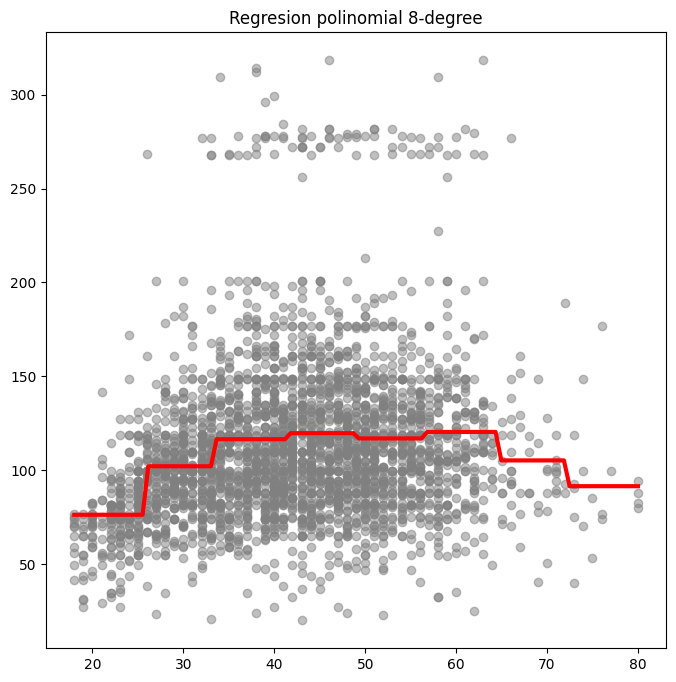

In [ ]:
# Vamos a graficar el modelo mas optimo (d = 8)
age_grid = np.linspace(wage["age"].min(),
                      wage["age"].max(),
                      100)
fig, ax = plt.subplots(figsize=(8,8))
# Grafico de los puntos
ax.scatter(age, y, facecolor="gray", alpha=.5)
# Graficando la funcion estimada
ax.plot(age_grid, best_estimator.predict(np.reshape(age_grid, (-1 ,1))),
        color="red",
        linewidth=3)
ax.set_title("Regresion polinomial 8-degree")

Podemos apreciar que el mejhor modelo es un de 8-degree

### b

In [ ]:
# ahora vamos a buscar los cortes para un step function
scores = []
cuts = np.arange(1, 20)
kfold = skm.KFold(10,
              shuffle=True,
              random_state=2)
for c in cuts:
  wage["cut"] = pd.cut(wage["age"], c)
  design = MS(["cut"])
  X = design.fit_transform(wage)

  results = skm.cross_validate(skl.LinearRegression(),
                               X,
                               wage["wage"],
                               scoring="neg_mean_squared_error",
                               cv=kfold)

  scores.append(np.mean(-results["test_score"]))

Text(0, 0.5, 'MSE')

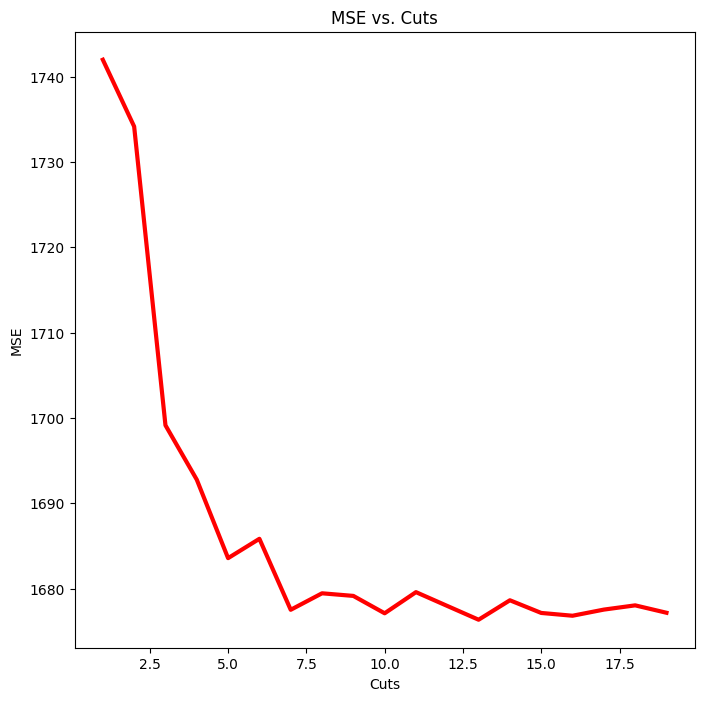

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(cuts, scores,
        linewidth=3,
        color="red")
ax.set_title("MSE vs. Cuts")
ax.set_xlabel("Cuts")
ax.set_ylabel("MSE")


El número óptimo de cortes es: 13
MSE mínimo: 1676.3553


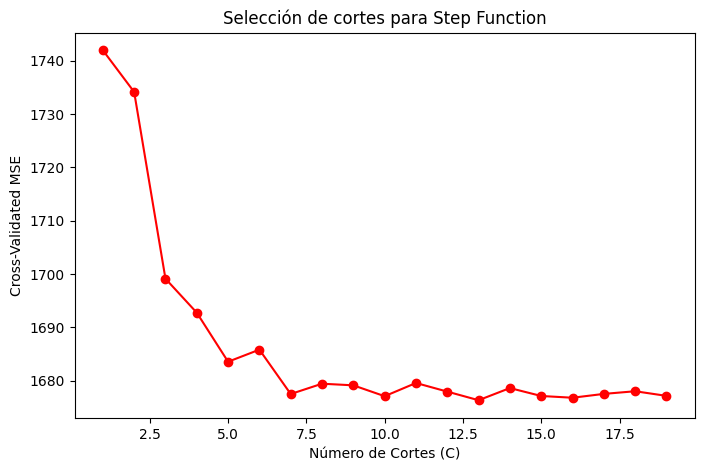

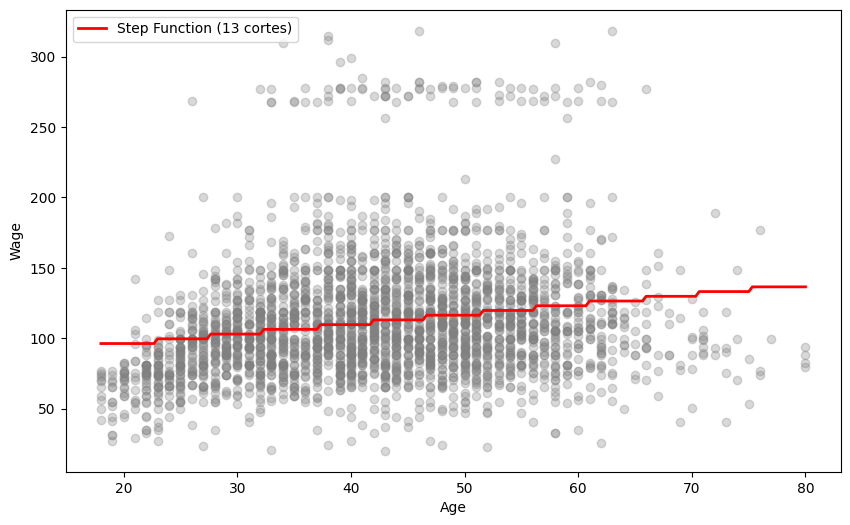

In [ ]:
import matplotlib.pyplot as plt

# 1. Encontrar el mejor 'C' (número de cortes)
best_c_idx = np.argmin(scores)
best_c = cuts[best_c_idx]
print(f"El número óptimo de cortes es: {best_c}")
print(f"MSE mínimo: {scores[best_c_idx]:.4f}")

# Graficar el error para ver el "codo"
plt.figure(figsize=(8, 5))
plt.plot(cuts, scores, marker='o', color='red')
plt.xlabel("Número de Cortes (C)")
plt.ylabel("Cross-Validated MSE")
plt.title("Selección de cortes para Step Function")
plt.show()

# ---------------------------------------------------------
# 2. Graficar el ajuste final (Fit) con el 'best_c'
# ---------------------------------------------------------

# A. Re-entrenar el modelo con TODOS los datos y el mejor corte
wage["cut"] = pd.cut(wage["age"], best_c)
design = MS(["cut"])
X_full = design.fit_transform(wage)
final_model = skl.LinearRegression().fit(X_full, wage["wage"])

# B. Crear datos ficticios para dibujar la línea escalonada
# Usamos linspace para tener muchos puntos y que se vean los escalones
age_grid = np.linspace(wage["age"].min(), wage["age"].max(), 200)
df_grid = pd.DataFrame({"age": age_grid})

# IMPORTANTE: Usar los mismos cortes (bins) que los datos originales
# Para que coincida exacto, le pasamos los mismos bordes o dejamos que pandas lo infiera igual
# Lo más seguro es usar 'retbins=True' en el original, pero aquí pd.cut suele ser consistente
df_grid["cut"] = pd.cut(df_grid["age"], bins=best_c)

# Transformar y Predecir
# Nota: Puede que necesites manejar bordes si linspace se sale por decimales,
# pero pd.cut suele aguantarlo bien.
X_grid = design.transform(df_grid)
preds = final_model.predict(X_grid)

# C. Plot Final
fig, ax = plt.subplots(figsize=(10, 6))
# Puntos reales (gris)
ax.scatter(wage["age"], wage["wage"], facecolor="gray", alpha=0.3)
# Línea de predicción (roja)
ax.plot(age_grid, preds, color="red", linewidth=2, label=f"Step Function ({best_c} cortes)")

ax.set_xlabel("Age")
ax.set_ylabel("Wage")
ax.legend()
plt.show()

## 7

In [ ]:
# vamos a tomar en cuenta algunos features ignorados hasta ahora/
wage = load_data("Wage")
wage.head()

year  age            maritl      race        education              region  \
0  2006   18  1. Never Married  1. White     1. < HS Grad  2. Middle Atlantic   
1  2004   24  1. Never Married  1. White  4. College Grad  2. Middle Atlantic   
2  2003   45        2. Married  1. White  3. Some College  2. Middle Atlantic   
3  2003   43        2. Married  3. Asian  4. College Grad  2. Middle Atlantic   
4  2005   50       4. Divorced  1. White       2. HS Grad  2. Middle Atlantic   

         jobclass          health health_ins   logwage        wage  
0   1. Industrial       1. <=Good      2. No  4.318063   75.043154  
1  2. Information  2. >=Very Good      2. No  4.255273   70.476020  
2   1. Industrial       1. <=Good     1. Yes  4.875061  130.982177  
3  2. Information  2. >=Very Good     1. Yes  5.041393  154.685293  
4  2. Information       1. <=Good     1. Yes  4.318063   75.043154

In [ ]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        3000 non-null   int64   
 1   age         3000 non-null   int64   
 2   maritl      3000 non-null   category
 3   race        3000 non-null   category
 4   education   3000 non-null   category
 5   region      3000 non-null   category
 6   jobclass    3000 non-null   category
 7   health      3000 non-null   category
 8   health_ins  3000 non-null   category
 9   logwage     3000 non-null   float64 
 10  wage        3000 non-null   float64 
dtypes: category(7), float64(2), int64(2)
memory usage: 115.5 KB


In [ ]:
wage.describe()

year          age      logwage         wage
count  3000.000000  3000.000000  3000.000000  3000.000000
mean   2005.791000    42.414667     4.653905   111.703608
std       2.026167    11.542406     0.351753    41.728595
min    2003.000000    18.000000     3.000000    20.085537
25%    2004.000000    33.750000     4.447158    85.383940
50%    2006.000000    42.000000     4.653213   104.921507
75%    2008.000000    51.000000     4.857332   128.680488
max    2009.000000    80.000000     5.763128   318.342430

In [ ]:
wage.describe(include="category")

maritl      race   education              region       jobclass  \
count         3000      3000        3000                3000           3000   
unique           5         4           5                   1              2   
top     2. Married  1. White  2. HS Grad  2. Middle Atlantic  1. Industrial   
freq          2074      2480         971                3000           1544   

                health health_ins  
count             3000       3000  
unique               2          2  
top     2. >=Very Good     1. Yes  
freq              2142       2083

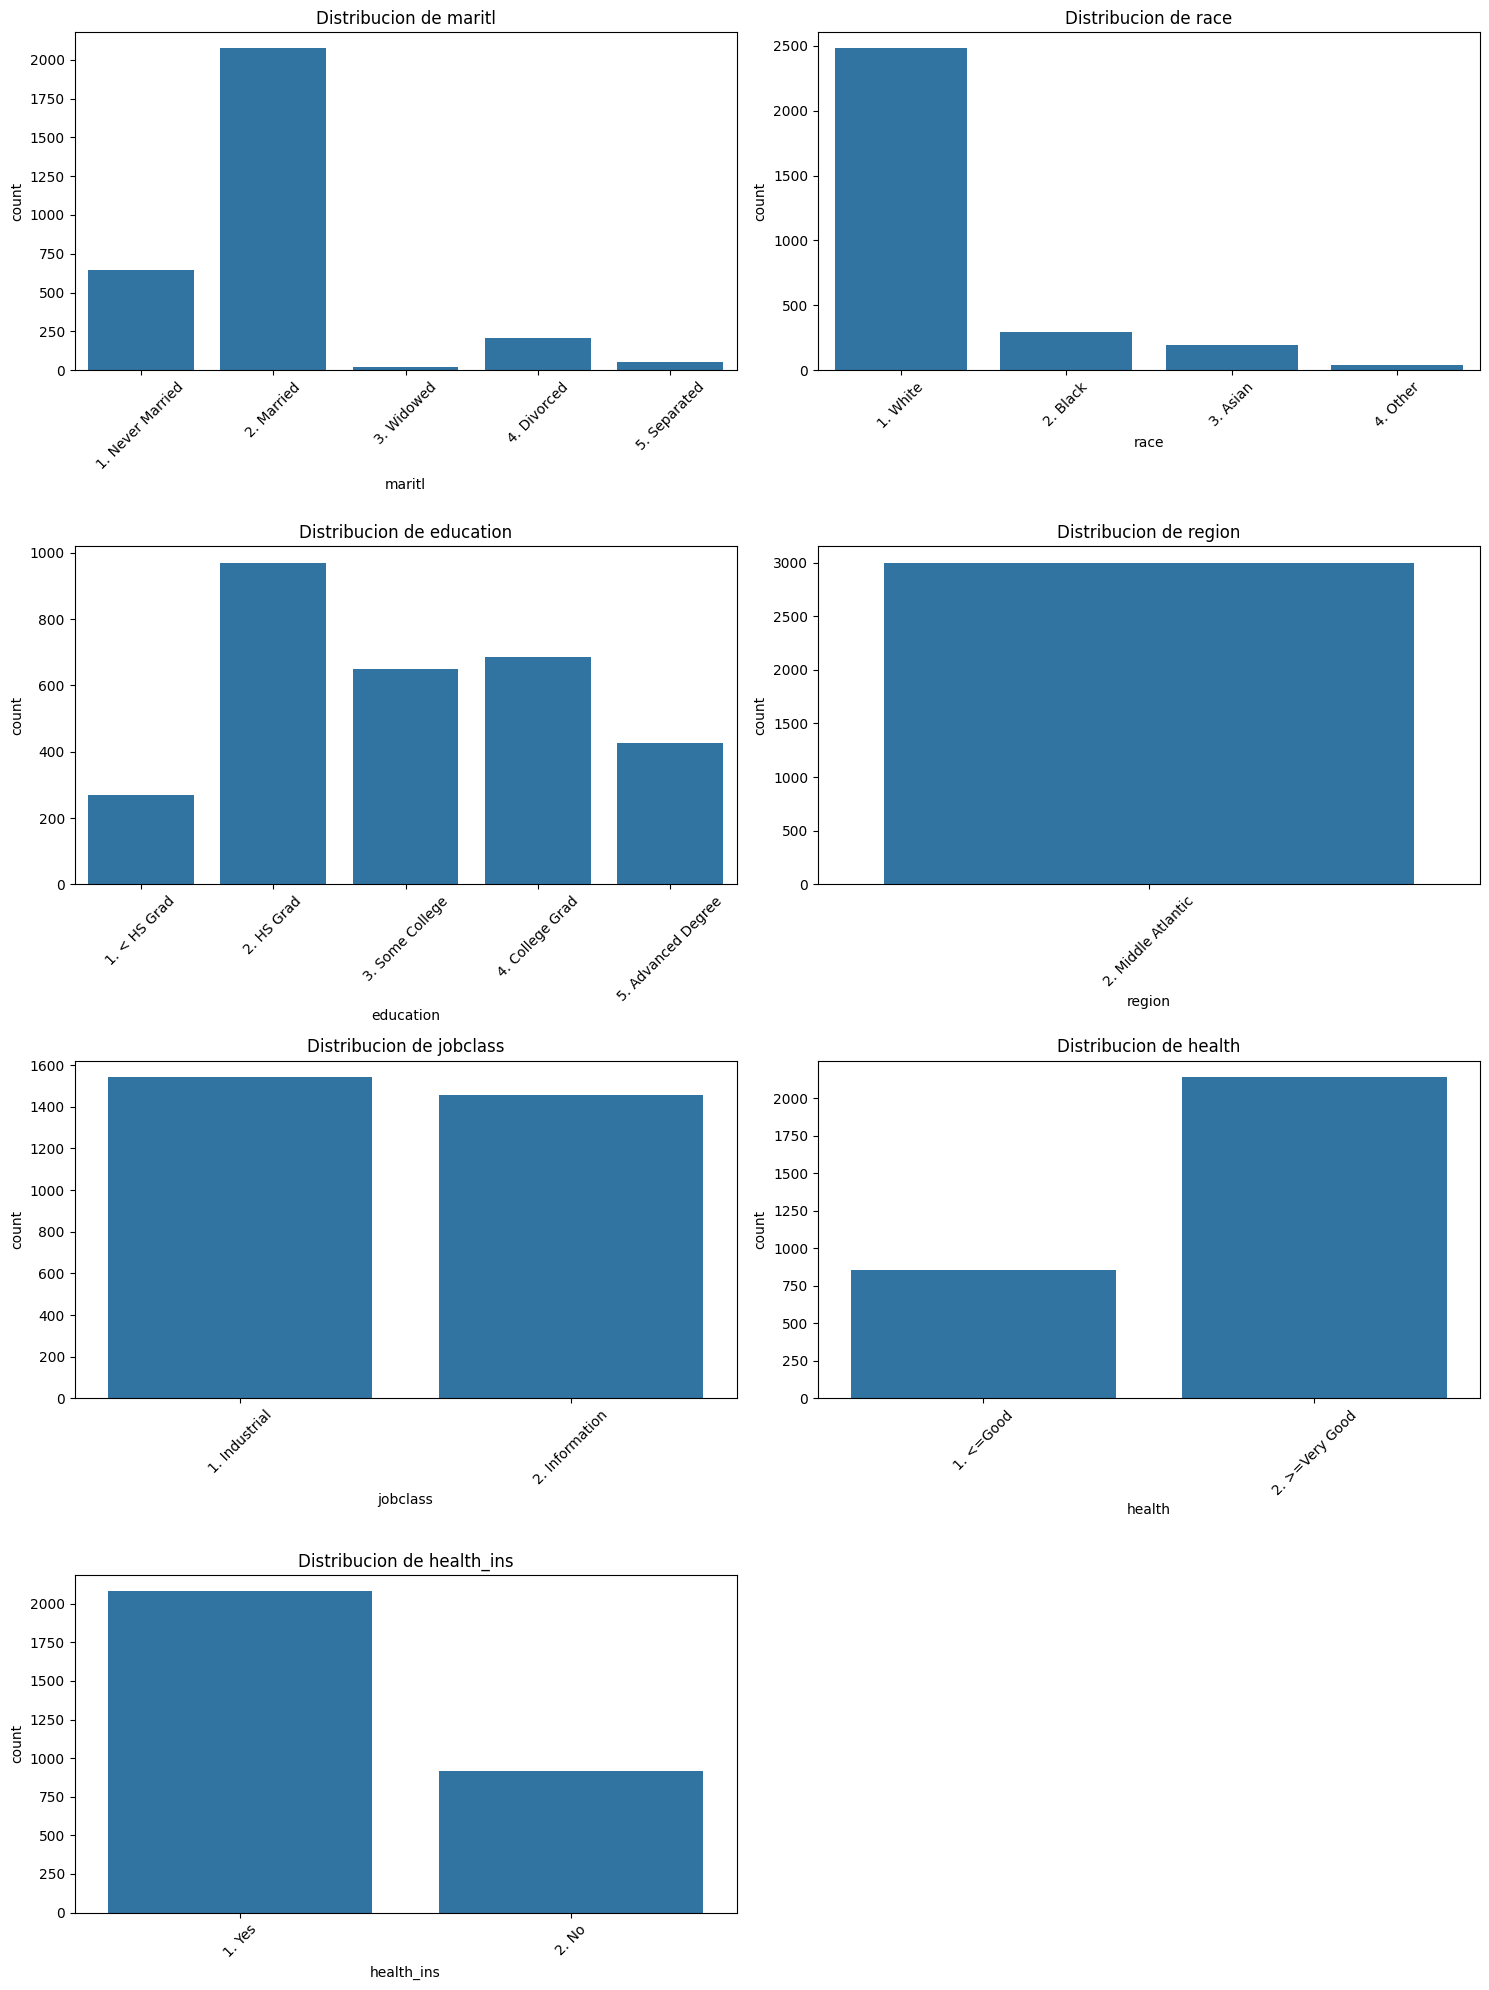

In [ ]:
cat_cols = wage.select_dtypes(include="category").columns

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(15,20))

ax = ax.flatten()

for i, col in enumerate(cat_cols):
  sns.countplot(data=wage, x=col, ax=ax[i])
  ax[i].tick_params(axis="x", rotation=45)
  ax[i].set_title(f"Distribucion de {col}")
for i in range(len(cat_cols), len(ax)):
  fig.delaxes(ax[i])
plt.tight_layout()
plt.show()

In [ ]:
# ahora vamos a ahcer un modelo GAM smoothing splines
# Vamos a tomar en cuenta y: wage X: jobclass, age, education
# matriz de features

gam_full = LinearGAM(s_gam(0)+ f_gam(1, lam=0) + f_gam(2, lam=0))

Xgam = np.column_stack([
                        wage["age"],
                        wage["jobclass"].cat.codes,
                         wage.education.cat.codes])
y = wage.wage
gam_full.fit(Xgam,y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + f(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [ ]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
gam_full.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + f(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

Text(0.5, 1.0, 'Partial dependence of education on wage - lam=0')

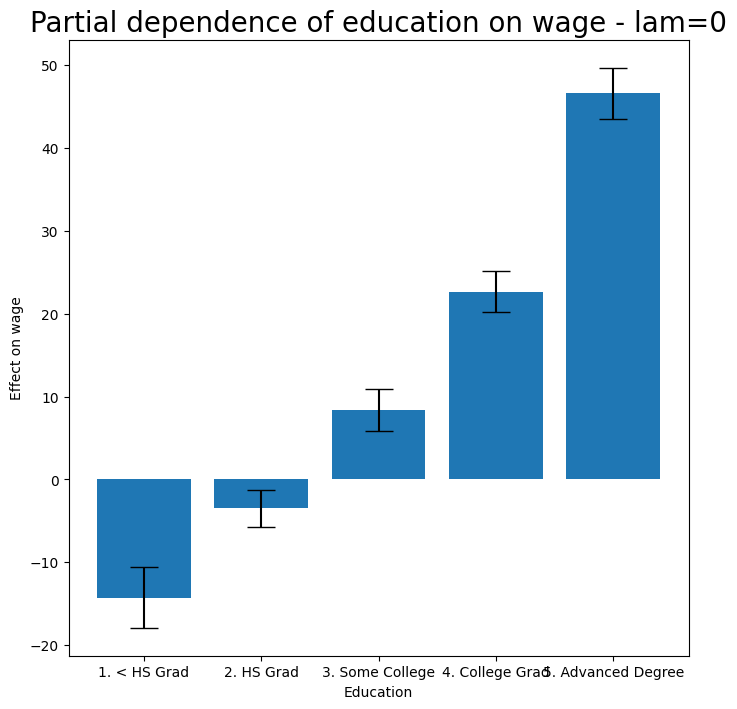

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot_gam(gam_full,2, ax=ax)
ax.set_xticklabels(wage.education.cat.categories)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of education on wage - lam=0',
fontsize=20)

Text(0.5, 1.0, 'Partial dependence of jobClas on wage - lam=0')

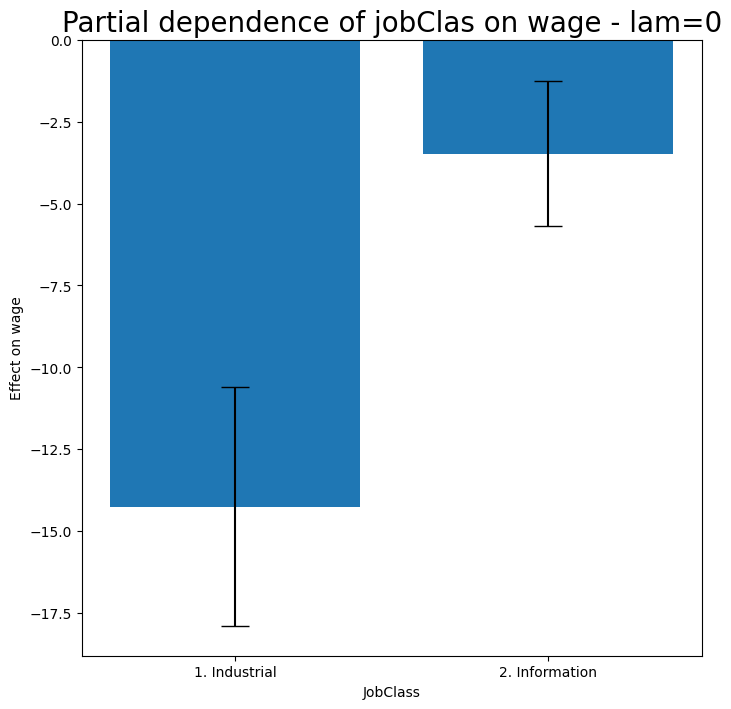

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot_gam(gam_full,1, ax=ax)
ax.set_xticklabels(wage.jobclass.cat.categories)
ax.set_xlabel('JobClass')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of jobClas on wage - lam=0',
fontsize=20)

Text(0.5, 1.0, 'Partial dependence of age on wage - lam=0')

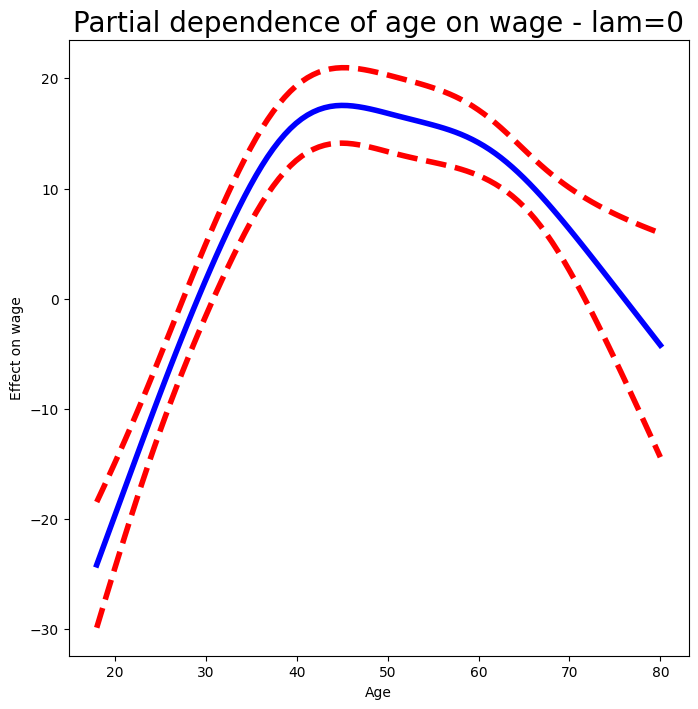

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot_gam(gam_full,0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - lam=0',
fontsize=20)

In [ ]:
def fit_gam(cols, df):
  cat_cols = df.select_dtypes(include=["category", "object"]).columns
  gam_terms = [f_gam(i, lam=0) if col in cat_cols else s_gam(i) for i, col in enumerate(cols)]
  Xgam = np.column_stack([df[col].cat.codes if col in cat_cols else df[col] for col in cols] )
  y = df["wage"]
  gam = LinearGAM(np.sum(gam_terms))
  return gam.fit(Xgam, y)

def plot_gam_terms(gam, columns: list, df:pd.DataFrame, y_name:str):
  """
  A simple function that plots partial gam plots on one figure
  """
  cat_cols = df.select_dtypes(include=['object', 'category']).columns

  n_plots = len(columns)
  n_rows = math.ceil(n_plots/3)
  n_cols = math.ceil(n_plots/n_rows)

  _, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
  axes = axes.flatten()

  for i, col in enumerate(columns):
      ax = axes[i]

      plot_gam(gam, i, ax=ax)

      ax.set_xlabel(col)
      ax.set_ylabel(f'Effect on {y_name}')
      ax.set_title(f'Partial dependence of {col} on {y_name}')

      if col in cat_cols:
          ax.set_xticklabels(df[col].cat.categories)
          ax.tick_params(axis='x', labelrotation=23)

  plt.tight_layout()

In [ ]:
def fit_gam(columns: list, df: pd.DataFrame) -> LinearGAM:
    """
    A simple function that fits gam models using factor terms with lam=0 for categorical variables
    and spline terms with default lam=0.6 for numerical variables.
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    gam_terms = [f_gam(i, lam=0) if col in cat_cols else s_gam(i) for i, col in enumerate(columns)]
    X_terms = [df[col].cat.codes if col in cat_cols else df[col] for col in columns]

    gam = LinearGAM(np.sum(gam_terms))
    Xgam = np.column_stack(X_terms)
    return gam.fit(Xgam, y)


def plot_gam_terms(gam, columns: list, df:pd.DataFrame, y_name:str):
    """
    A simple function that plots partial gam plots on one figure
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    n_plots = len(columns)
    n_rows = math.ceil(n_plots/3)
    n_cols = math.ceil(n_plots/n_rows)

    _, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]

        plot_gam(gam, i, ax=ax)

        ax.set_xlabel(col)
        ax.set_ylabel(f'Effect on {y_name}')
        ax.set_title(f'Partial dependence of {col} on {y_name}')

        if col in cat_cols:
            ax.set_xticklabels(df[col].cat.categories)
            ax.tick_params(axis='x', labelrotation=23)

    plt.tight_layout()

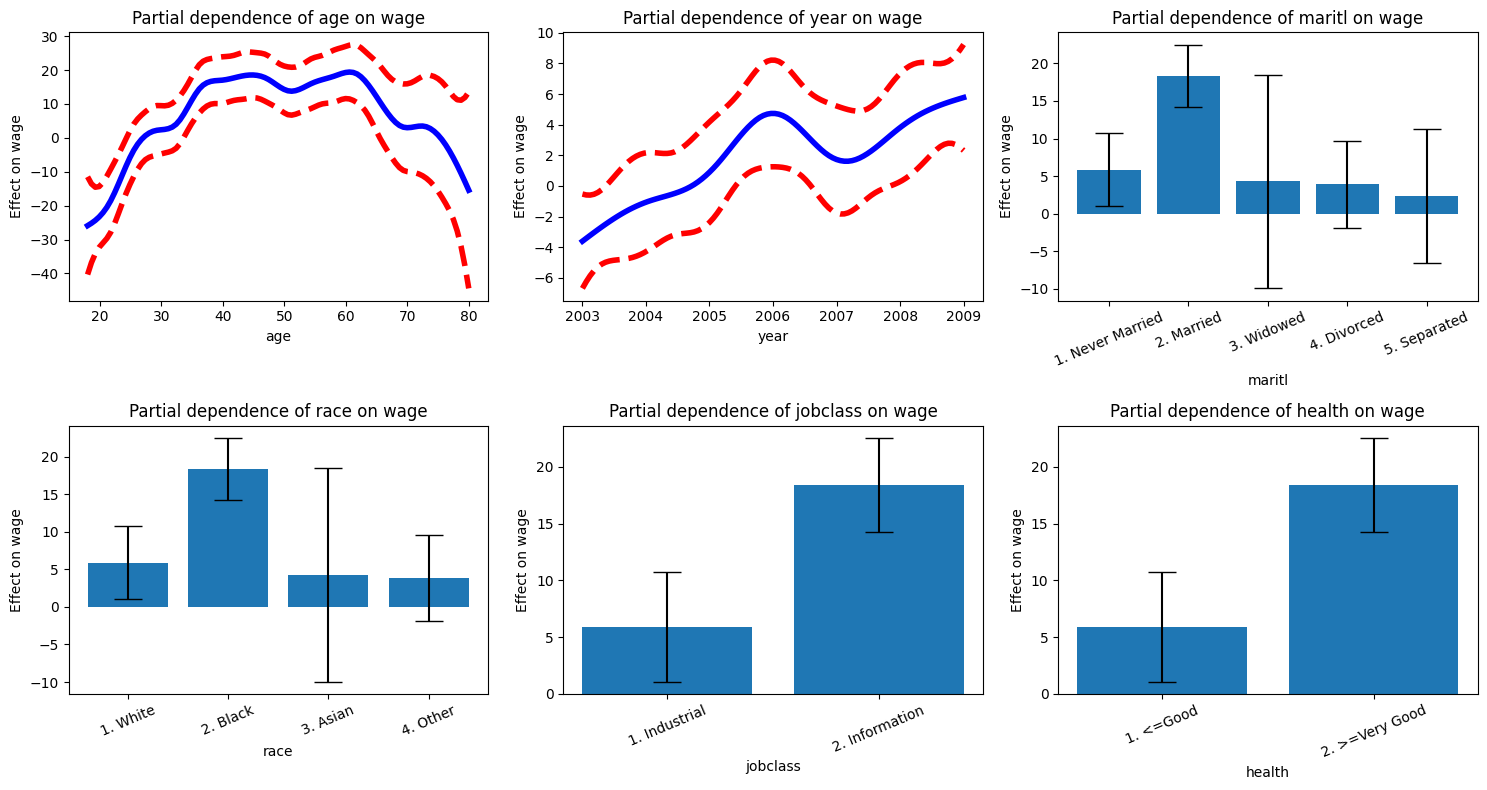

In [ ]:
cols = ['age', 'year', 'maritl', "race", "jobclass", "health"]
gam_maritl = fit_gam(cols, wage)
plot_gam_terms(gam_maritl, cols, wage, 'wage')

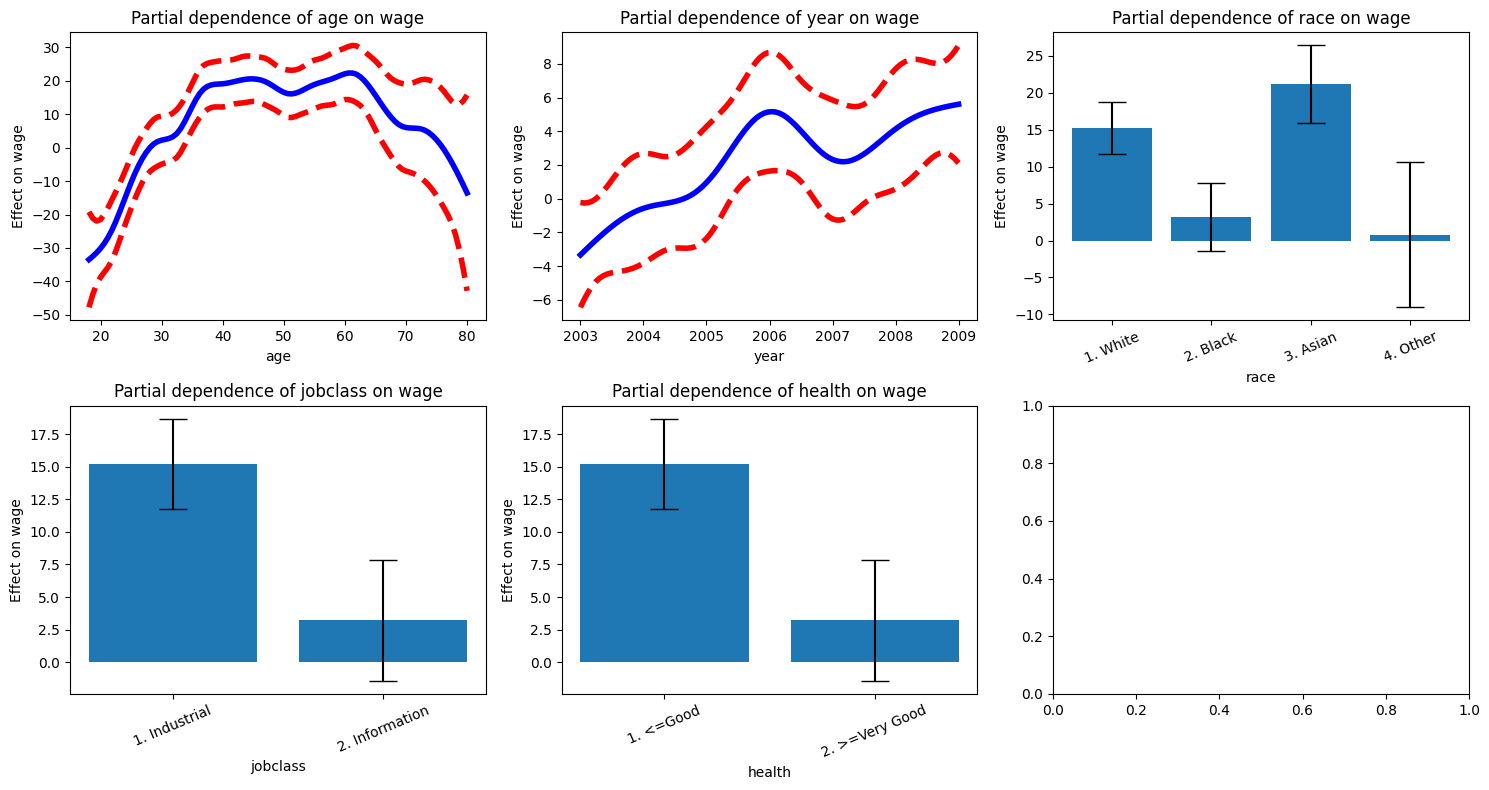

In [ ]:
cols = ['age', 'year', "race", "jobclass", "health"]
gam_sin_maritl = fit_gam(cols, wage)
plot_gam_terms(gam_sin_maritl, cols, wage, 'wage')

In [ ]:
print(anova_gam(gam_sin_maritl, gam_maritl))

        deviance           df  deviance_diff   df_diff         F    pvalue
0  114167.995576  2973.803599            NaN       NaN       NaN       NaN
1  112863.906356  2969.806900     1304.08922  3.996699  8.585766  0.000095


## 8

Vamos a ahondar en el data set Auto. Existe alguna relacion no lineal entre los regresores ?


In [ ]:
auto = load_data("Auto")

index_names = auto.index
auto = auto.reset_index().drop("name", axis=1)

In [ ]:
auto.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
dtype: int64

In [ ]:
auto.describe()

mpg   cylinders  displacement  horsepower       weight  \
count  392.000000  392.000000    392.000000  392.000000   392.000000   
mean    23.445918    5.471939    194.411990  104.469388  2977.584184   
std      7.805007    1.705783    104.644004   38.491160   849.402560   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.000000    4.000000    105.000000   75.000000  2225.250000   
50%     22.750000    4.000000    151.000000   93.500000  2803.500000   
75%     29.000000    8.000000    275.750000  126.000000  3614.750000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       acceleration        year      origin  
count    392.000000  392.000000  392.000000  
mean      15.541327   75.979592    1.576531  
std        2.758864    3.683737    0.805518  
min        8.000000   70.000000    1.000000  
25%       13.775000   73.000000    1.000000  
50%       15.500000   76.000000    1.000000  
75%       17.025000   79.000000    2.000000  
max       24.800000   82.000000    3.000000

<Axes: >

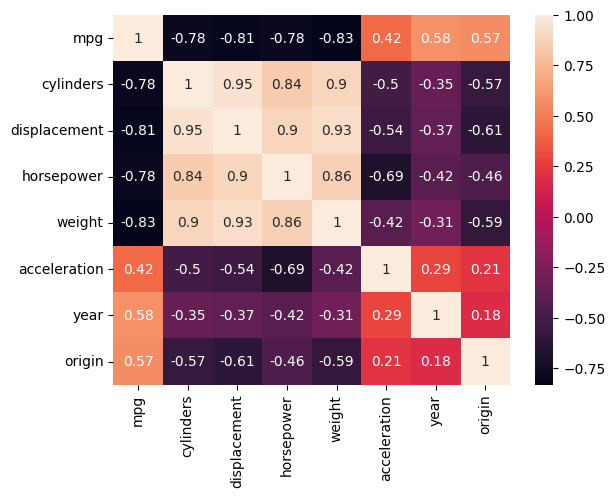

In [ ]:
sns.heatmap(auto.corr(), annot=True)

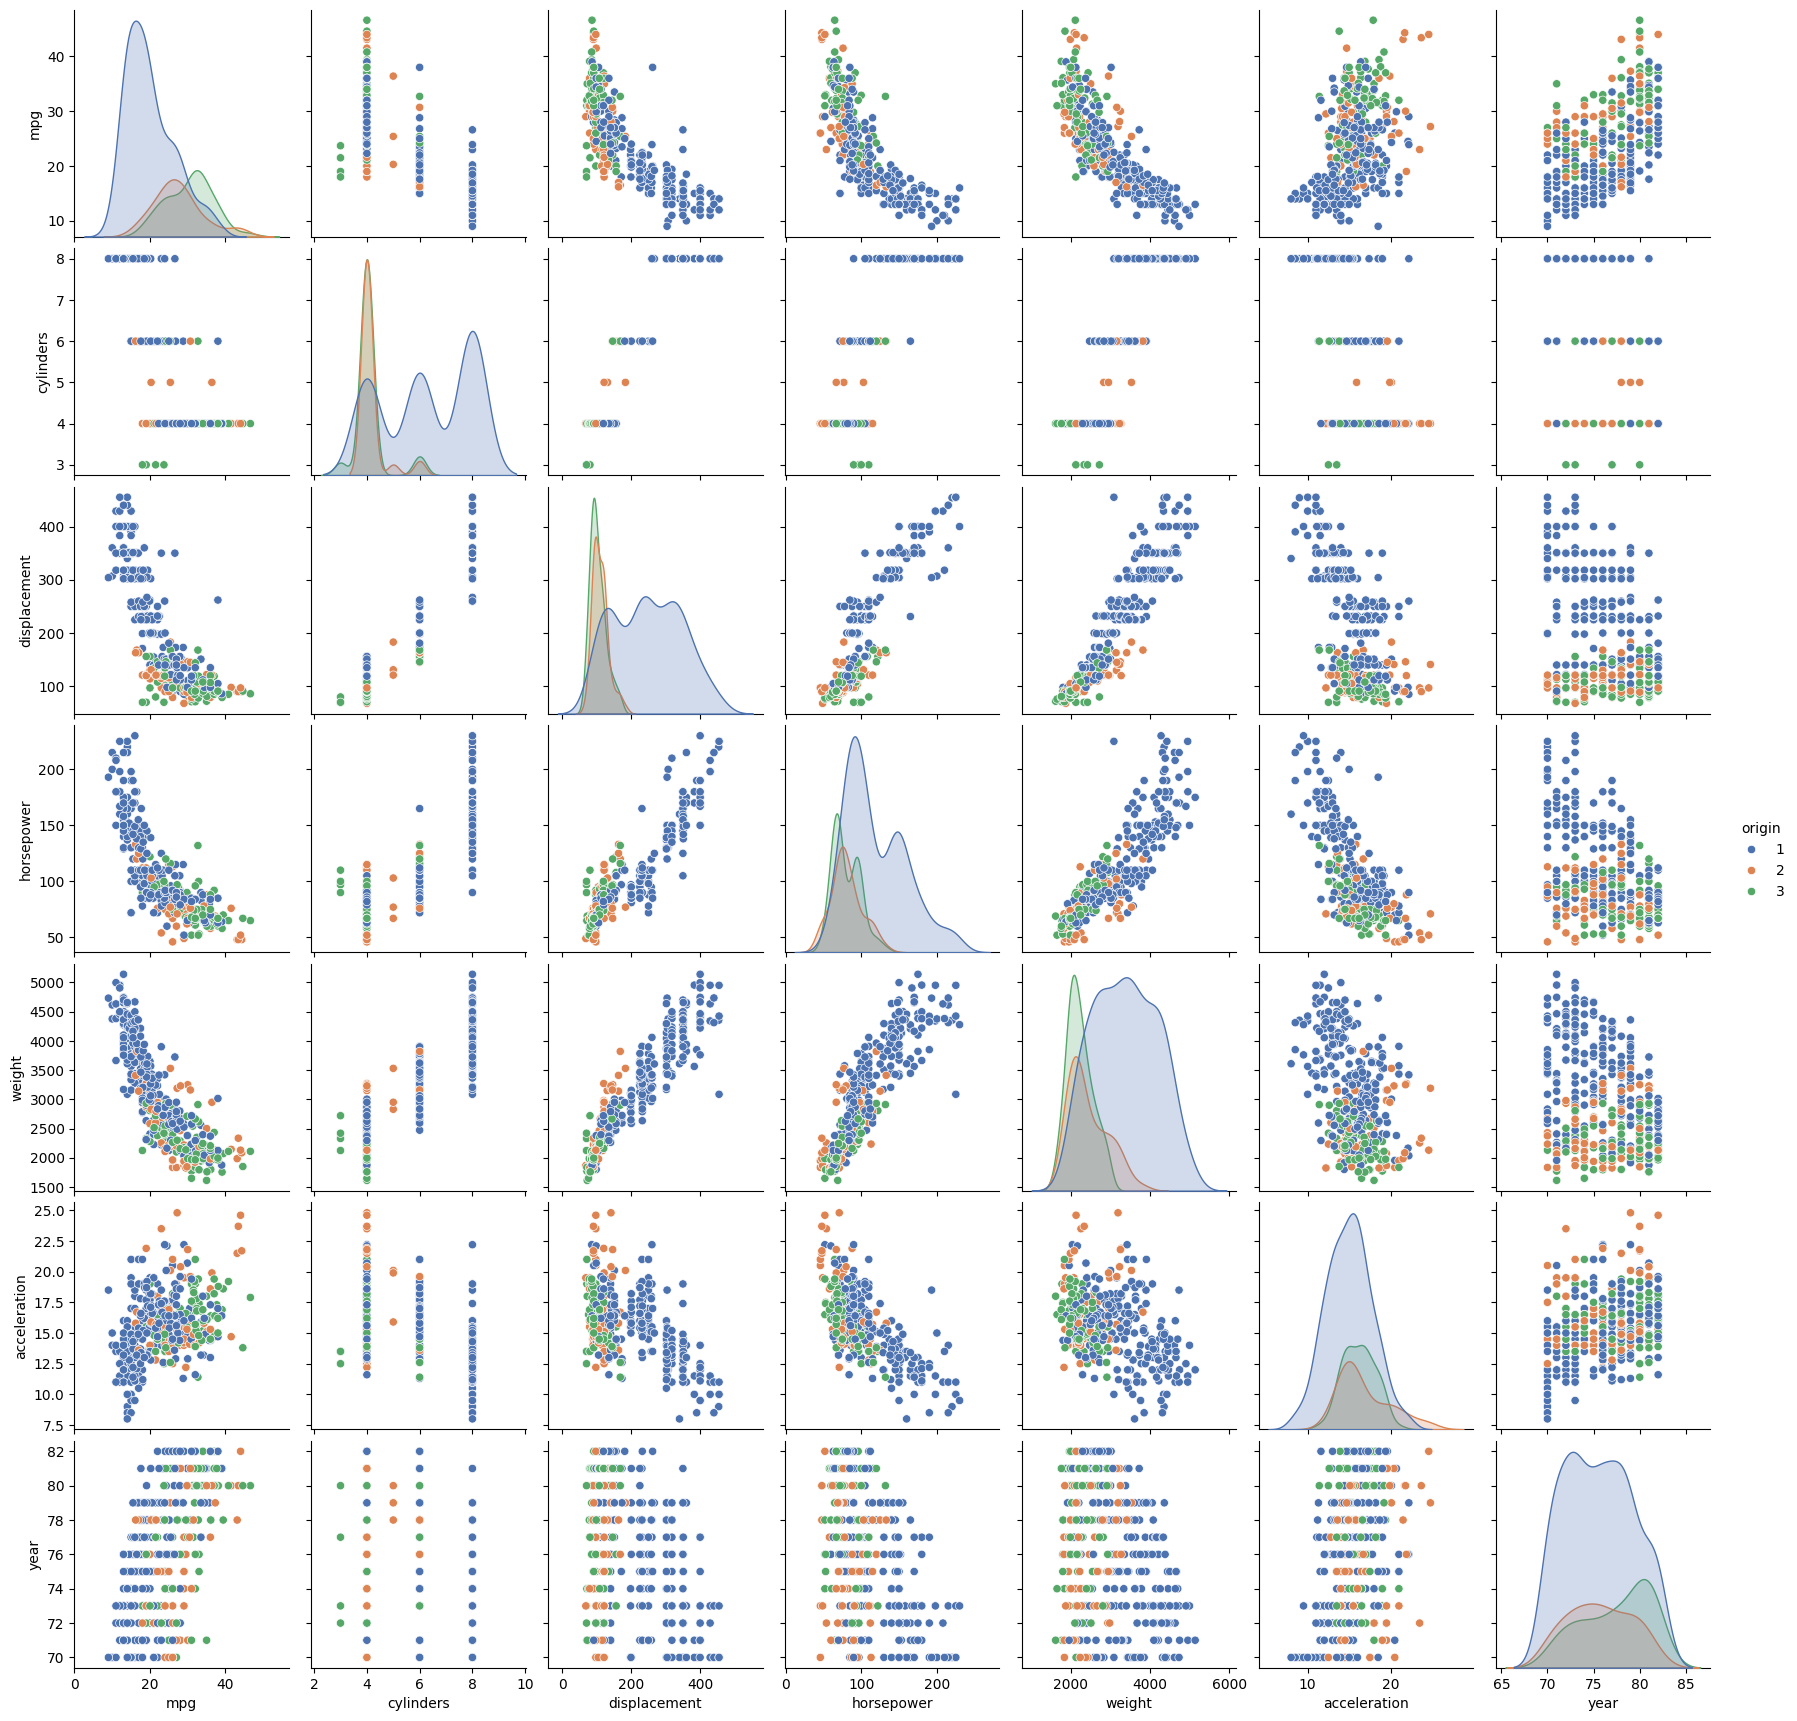

In [ ]:
sns.pairplot(auto, hue="origin", palette="deep")

In [ ]:
auto

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0    18.0          8         307.0         130    3504          12.0    70   
1    15.0          8         350.0         165    3693          11.5    70   
2    18.0          8         318.0         150    3436          11.0    70   
3    16.0          8         304.0         150    3433          12.0    70   
4    17.0          8         302.0         140    3449          10.5    70   
..    ...        ...           ...         ...     ...           ...   ...   
387  27.0          4         140.0          86    2790          15.6    82   
388  44.0          4          97.0          52    2130          24.6    82   
389  32.0          4         135.0          84    2295          11.6    82   
390  28.0          4         120.0          79    2625          18.6    82   
391  31.0          4         119.0          82    2720          19.4    82   

     origin  
0         1  
1         1  
2         1  
3         1  
4         1  
..      ...  
387       1  
388       2  
389       1  
390       1  
391       1  

[392 rows x 8 columns]

In [ ]:
auto.drop("mpg", axis=1).columns

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'year', 'origin'],
      dtype='object')

In [ ]:
# Veamos una regresion multiple con los features del data set
# Datos

kfold = skm.KFold(5, shuffle=True, random_state=2)

design = MS(auto.drop("mpg", axis=1).columns)

pipe  = Pipeline([("design", design),
                  ("linreg", skl.LinearRegression())])

results = skm.cross_validate(pipe,
                             auto,
                             auto["mpg"],
                             cv = kfold,
                             scoring="neg_mean_squared_error")
np.mean(-results["test_score"])


np.float64(11.316438099675246)

In [ ]:
results

{'fit_time': array([0.07936382, 0.05770946, 0.03531957, 0.07057428, 0.04589987]),
 'score_time': array([0.02554345, 0.04580259, 0.01928139, 0.01281095, 0.03693867]),
 'test_score': array([-11.66916683,  -9.03417739, -10.85983319, -14.42821185,
        -10.59080124])}

Ahora vamos a buscar un modelo con variables reducidas teniendo en cuenta la correlacion entre estos.

In [ ]:
cols = ["weight", "acceleration", "year", "origin"]

design = MS(cols)

pipe  = Pipeline([("design", design),
                  ("linreg", skl.LinearRegression())])

results = skm.cross_validate(pipe,
                             auto,
                             auto["mpg"],
                             cv = kfold,
                             scoring="neg_mean_squared_error")
np.mean(-results["test_score"])



np.float64(11.234718148576436)

Podemos apreciar que al menos en un modelo lineal existe ciertas variables las cuales ofrecen informacion repetitiva. en este caso eliminandolos tenemos un modelo lineal con resultados bastante similares, pero mas simple a nivel de features.

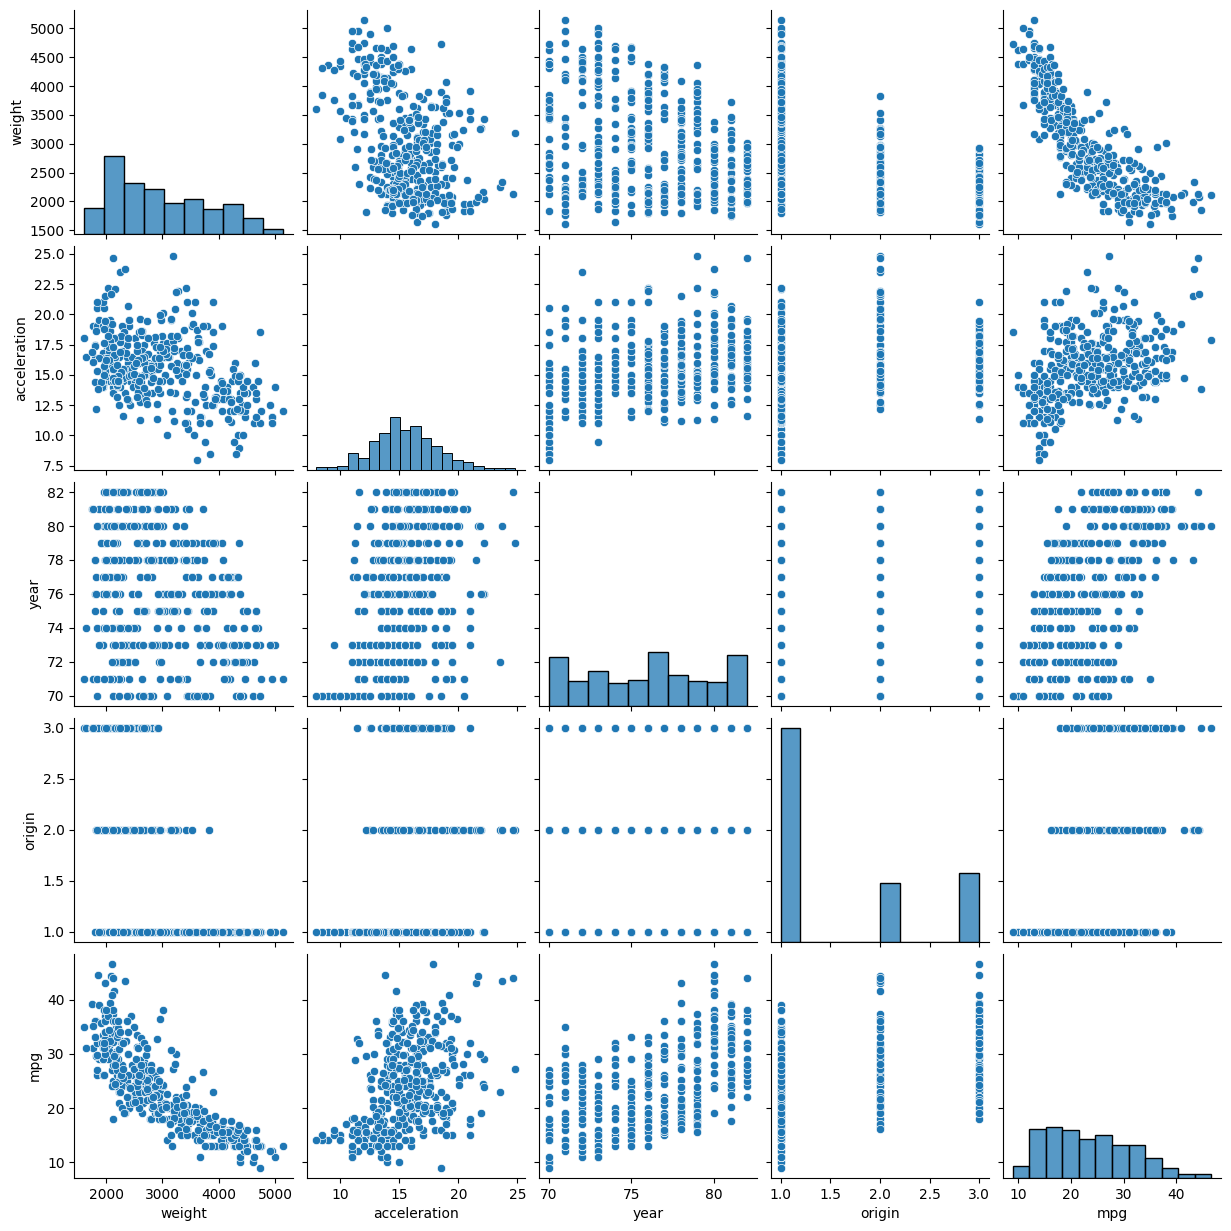

In [ ]:
cols = ["weight", "acceleration", "year", "origin", "mpg"]
sns.pairplot(auto[cols])


Veamos una regresion polinomica teniendo en cuenta solo weight

In [ ]:
kfold = skm.KFold(5, shuffle=True, random_state=2)

pipe = Pipeline([("poly", PolynomialFeatures(include_bias=False)),
                 ("linreg", skl.LinearRegression())])

params = {"poly__degree": np.arange(1, 10)}

search = skm.GridSearchCV(pipe,
                          params,
                          cv=kfold,
                          scoring="neg_mean_squared_error").fit(auto[["weight"]],
                                                                auto["mpg"])
search

GridSearchCV(cv=KFold(n_splits=5, random_state=2, shuffle=True),
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('linreg', LinearRegression())]),
             param_grid={'poly__degree': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='neg_mean_squared_error')

In [ ]:
best_model = search.best_estimator_
best_model

Pipeline(steps=[('poly',
                 PolynomialFeatures(degree=np.int64(2), include_bias=False)),
                ('linreg', LinearRegression())])

In [ ]:
search.best_score_

np.float64(-17.599110159710236)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


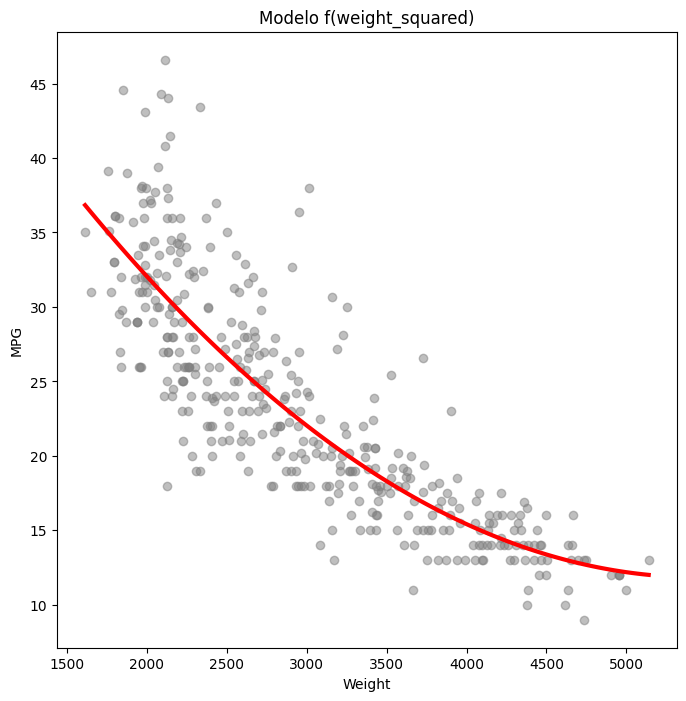

In [ ]:
weight = np.linspace(auto["weight"].min(),
                     auto["weight"].max(),
                     100)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(auto["weight"], auto["mpg"], facecolor="gray", alpha=.5)
ax.plot(weight, best_model.predict(np.reshape(weight, (-1,1))),
        color="red",
        linewidth=3)
ax.set_title("Modelo f(weight_squared)")
ax.set_xlabel("Weight")
ax.set_ylabel("MPG")
plt.show()

Veamos un modelo con weight cuadratico y el resto lineal

In [ ]:
poly_cols = ["weight"]
linear_cols = ["acceleration", "year", "origin"]

X = auto[poly_cols + linear_cols]
y = auto["mpg"]

preprocesor = ColumnTransformer([("poly", PolynomialFeatures(degree=2, include_bias=False), poly_cols),
                                 ("linear", "passthrough", linear_cols)])

pipe = Pipeline([("preprocesor", preprocesor),
                 ("linreg", skl.LinearRegression())])

kfold = skm.KFold(5, shuffle=True, random_state=2)

results = skm.cross_validate(pipe,
                             X,
                             y,
                             cv=kfold,
                             scoring="neg_mean_squared_error")
np.mean(results["test_score"])

np.float64(-9.098155663234415)

In [ ]:
cols

['weight', 'acceleration', 'year', 'origin', 'mpg']

Ahora veamos el caso de acceleraion

In [ ]:
kfold = skm.KFold(5, shuffle=True, random_state=2)

pipe = Pipeline([("poly", PolynomialFeatures(include_bias=False)),
                 ("linreg", skl.LinearRegression())])

params = {"poly__degree": np.arange(1, 10)}

search = skm.GridSearchCV(pipe,
                          params,
                          cv=kfold,
                          scoring="neg_mean_squared_error").fit(auto[["acceleration"]],
                                                                auto["mpg"])
search

GridSearchCV(cv=KFold(n_splits=5, random_state=2, shuffle=True),
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('linreg', LinearRegression())]),
             param_grid={'poly__degree': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='neg_mean_squared_error')

In [ ]:
search.best_params_

{'poly__degree': np.int64(4)}

armando el modelo con un parametro de 4 en el polinomio

In [ ]:
kfold = skm.KFold(5, shuffle=True, random_state=2)

X = auto[cols]
y = auto["mpg"]

preprocesor = ColumnTransformer([("weight_poly", PolynomialFeatures(degree=2,
                                                               include_bias=False), ["weight"]),
                                 ("acce_poly", PolynomialFeatures(degree=4,
                                                                  include_bias=False), ["acceleration"]),
                                 ("linear", "passthrough", ["year", "origin"])])
pipe = Pipeline([("preprocesor", preprocesor),
                 ("scaler", StandardScaler()),
                 ("linreg", skl.LinearRegression())])

results = skm.cross_validate(pipe,
                             X,
                             y,
                             cv=kfold,
                             scoring="neg_mean_squared_error",
                             return_estimator=True)

np.mean(results["test_score"])

np.float64(-8.657107886017716)

Vaamos a aplicar un poco de regularizacion con Ridge, para no eliminar las variables con Lasso

In [ ]:
alphas_test = np.linspace(0.1, 10, 1000)
kfold = skm.KFold(5, shuffle=True, random_state=2)

X = auto[cols]
y = auto["mpg"]

preprocesor = ColumnTransformer([("weight_poly", PolynomialFeatures(degree=2,
                                                                    include_bias=False), ["weight"]),
                                 ("acce_poly", PolynomialFeatures(degree=4,
                                                                  include_bias=False), ["acceleration"]),
                                 ("linear", "passthrough", ["year", "origin"])])
pipe = Pipeline([("preprocesor", preprocesor),
                 ("scaler", StandardScaler()),
                 ("ridge", skl.RidgeCV(alphas=alphas_test))])
pipe.fit(X, y)
print(f"El valor de alpha encontrado es: {pipe.named_steps['ridge'].alpha_}")
pipe.named_steps["ridge"].alpha_
results = skm.cross_validate(pipe,
                             X,
                             y,
                             cv=kfold,
                             scoring="neg_mean_squared_error")
np.mean(results["test_score"])

El valor de alpha encontrado es: 0.14954954954954958


np.float64(-8.630819288521973)

Podemos apreciar que en el modelo multiple con un enfoque lineal se obtuvo un valor de 11 con el mse. COn la creacion de un modelo polinmomial en 2 y 4 grados para weight y acceleration. Obtuvimso una mejora hasta 8.7 en mse.

Posteriormente, l uego de una regularizacion obtenemos un mse de 8.5 lo cual es una ligera mejora. o una buena garantia de robustes ante datos nuevos.


ahora veremos un enoque con splines

In [ ]:
cols = ["weight", "acceleration", "year", "origin"]

In [ ]:
kfold = skm.KFold(5, shuffle=True, random_state=2)

spline_cols = ["weight", "acceleration"]
linear_cols = ["year", "origin"]

natural_spline = SplineTransformer(n_knots=5, degree=3,
                                   extrapolation="linear",
                                   include_bias=False)

preprocesor = ColumnTransformer([("spline_weight", SplineTransformer(degree=3,
                                                                     extrapolation="linear",
                                                                     include_bias=False), ["weight"]),

                                 ("spline_acce", SplineTransformer(degree=3,
                                                                   include_bias=False,
                                                                   extrapolation="linear"), ["acceleration"]),
                                 ("linear", "passthrough", linear_cols)])
pipe = Pipeline([("preprocesor", preprocesor),
                 ("scaler", StandardScaler()),
                 ("ridge", skl.Ridge())])

params = {"ridge__alpha": [0.1, 0.2, .5, 1, 2, 5, 10 ,100],
          "preprocesor__spline_weight__n_knots": np.arange(2, 12),
          "preprocesor__spline_acce__n_knots": np.arange(2, 12)}

search = skm.GridSearchCV(pipe,
                          params,
                          cv=kfold,
                          scoring="neg_mean_squared_error",
                          n_jobs=1)
search.fit(auto[cols], auto["mpg"])
search.best_params_


{'preprocesor__spline_acce__n_knots': np.int64(2),
 'preprocesor__spline_weight__n_knots': np.int64(3),
 'ridge__alpha': 0.2}

In [ ]:
# --- RESULTADOS NUMÉRICOS ---
best_mse = -search.best_score_

print(f"Mejor MSE Promedio: {best_mse:.4f}")

Mejor MSE Promedio: 8.6027


COn toda esta informacion podemos llegar a la siguiente conclusion:

El modelo demuiestra que tiene una relacion no linear para los features acceleration y weight dado que el modelo con un Spline de 3 y 2 degress respectivamente es mejor que el hallado con una regresion lineal multiple.

## 9)

In [ ]:
boston = load_data("Boston")

In [ ]:
boston.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

   lstat  medv  
0   4.98  24.0  
1   9.14  21.6  
2   4.03  34.7  
3   2.94  33.4  
4   5.33  36.2

In [ ]:
# Predictor: dis
boston.describe()[["dis", "nox"]]

dis         nox
count  506.000000  506.000000
mean     3.795043    0.554695
std      2.105710    0.115878
min      1.129600    0.385000
25%      2.100175    0.449000
50%      3.207450    0.538000
75%      5.188425    0.624000
max     12.126500    0.871000

<Axes: xlabel='dis', ylabel='nox'>

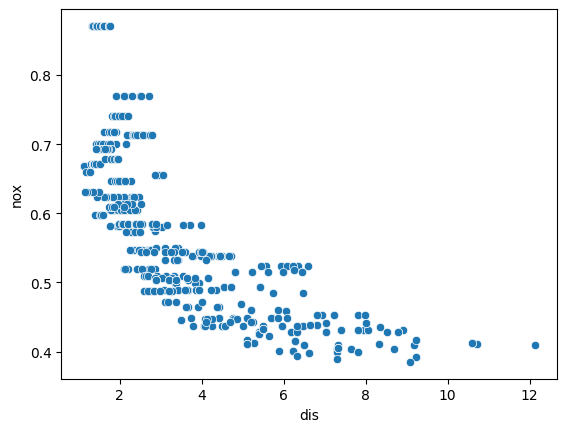

In [ ]:
sns.scatterplot(x="dis", y="nox", data=boston)

In [ ]:
np.corrcoef(boston["dis"], boston["nox"])

array([[ 1.        , -0.76923011],
       [-0.76923011,  1.        ]])

#### a

vamos a hacer una regresion polinomial de grado 3 tomando en cuenta dis como variable independiente y nox como la respuesta.

In [ ]:
design = MS([poly("dis", degree=3)]).fit(boston)

X = design.transform(boston)
y = boston["nox"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    nox   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     419.3
Date:                Sat, 07 Feb 2026   Prob (F-statistic):          2.71e-136
Time:                        14:09:35   Log-Likelihood:                 690.44
No. Observations:                 506   AIC:                            -1373.
Df Residuals:                     502   BIC:                            -1356.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                  0

In [ ]:
# vamos a plotear
grid_dis = np.linspace(boston["dis"].min(), boston["dis"].max(), 100)
data = pd.DataFrame(grid_dis,
                    columns=["dis"])
predicted = model.predict(design.transform(data))

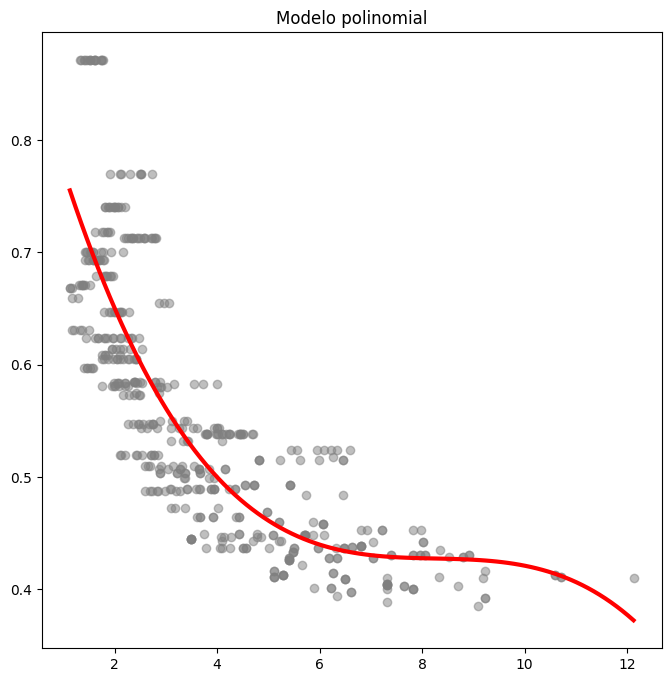

In [ ]:

figm,  ax = plt.subplots(figsize=(8,8))

ax.scatter(boston["dis"], y, facecolor="gray", alpha=.5)

ax.plot(data, predicted, color="red", linewidth=3)
ax.set_title("Modelo polinomial")
plt.show()

#### b

Text(0.5, 1.0, 'Modelo polinomial')

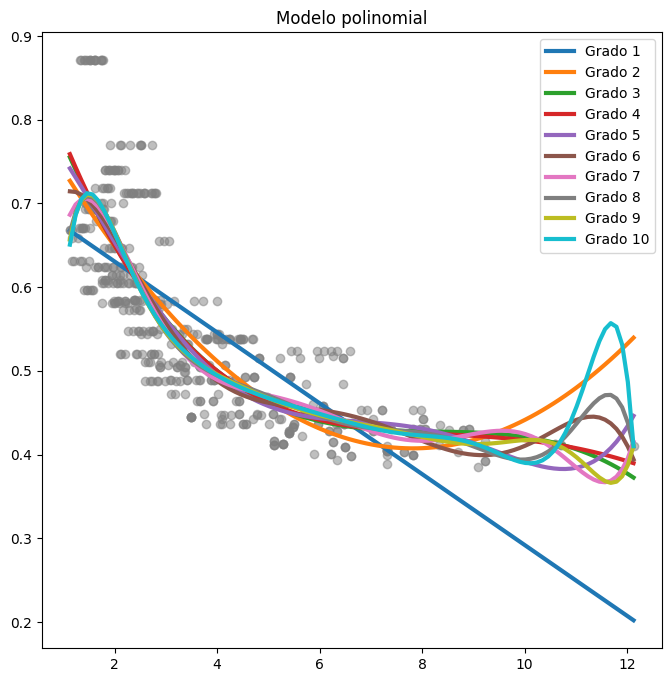

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(boston["dis"], y, facecolor="gray", alpha=.5)
for i in range(1, 11):
  design = MS([poly("dis", degree=i)])
  pipe = Pipeline([("design", design),
                  ("linreg", skl.LinearRegression())])
  pipe.fit(boston, boston["nox"])
  predicted = pipe.predict(data)
  ax.plot(data, predicted, linewidth=3, label=f"Grado {i}")
ax.legend()
ax.set_title("Modelo polinomial")




#### c

Vamos a realizar una busqueda de parametros utilizando grid search "

In [ ]:
kfold = skm.KFold(5, shuffle=True, random_state=2)

design = MS([poly("dis", degree=3)])

pipe = Pipeline([("design", design),
                 ("linreg", skl.LinearRegression())])

grid_models = [MS([poly("dis", degree=i)]) for i in range(1, 11)]

params = {"design": grid_models}

search = skm.GridSearchCV(pipe,
                          params,
                          cv=kfold,
                          scoring="neg_mean_squared_error").fit(boston,
                                                                boston["nox"])
search.best_params_


{'design': ModelSpec(terms=[Feature(variables=('dis',), name='poly(dis, degree=3)', encoder=Poly(degree=3), use_transform=True, pure_columns=False, override_encoder_colnames=True)])}

podemos apreciar que despues de una busqueda de parametros, el mejor modelo es el que tiene un polinomio de grado 3.

#### d

In [ ]:

design = MS([ns("dis", df=4)])

pipe = Pipeline([("design", design),
                 ("linreg", skl.LinearRegression())])

results = skm.cross_validate(pipe,
                             boston,
                             boston["nox"],
                             cv=kfold,
                             scoring="neg_mean_squared_error")
np.mean(-results["test_score"])


np.float64(0.0038251331429489236)

In [ ]:
pipe.fit(boston, boston["nox"])
pipe

Pipeline(steps=[('design',
                 ModelSpec(terms=[Feature(variables=('dis',), name='ns(dis, df=4)', encoder=NaturalSpline(df=4), use_transform=True, pure_columns=False, override_encoder_colnames=True)])),
                ('linreg', LinearRegression())])

Text(0.5, 1.0, 'Modelo polinomial')

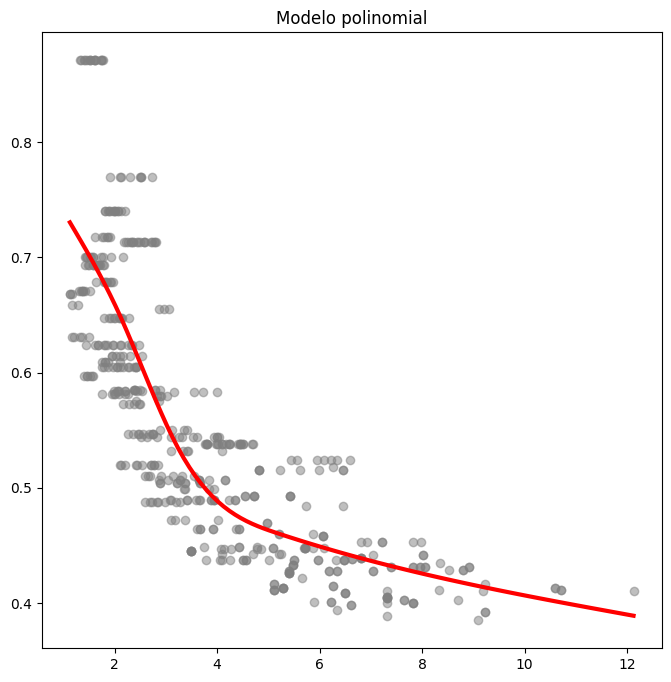

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(boston["dis"], boston["nox"], facecolor="gray", alpha=.5)
ax.plot(data, pipe.predict(data), color="red", linewidth=3)
ax.set_title("Modelo polinomial")

#### e Y FF

Ahora vamos a buscar mediante grid search el valor de los df y para cada caso vamos a graficar la funcion y tambien el mse.

In [ ]:
kfold = skm.KFold(10, shuffle=True, random_state=2)

design = [MS([ns("dis", df=i)]) for i in range(3, 10)]

pipe = Pipeline([("design", design),
                 ("linreg", skl.LinearRegression())])

params = {"design": design}

search = skm.GridSearchCV(pipe,
                          params,
                          cv=kfold,
                          scoring="neg_mean_squared_error")
search.fit(boston, boston["nox"])
search.best_params_

{'design': ModelSpec(terms=[Feature(variables=('dis',), name='ns(dis, df=8)', encoder=NaturalSpline(df=8), use_transform=True, pure_columns=False, override_encoder_colnames=True)])}

Text(0, 0.5, 'MSE')

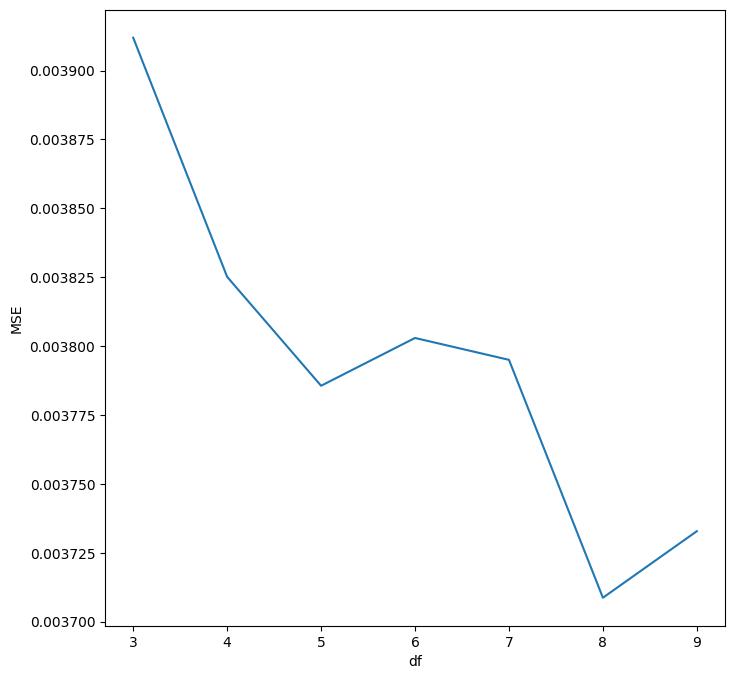

In [ ]:
results = pd.DataFrame(search.cv_results_)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.arange(3, 10), -results["mean_test_score"])
ax.set_xlabel("df")
ax.set_ylabel("MSE")

In [ ]:
results.params[1]


{'design': ModelSpec(terms=[Feature(variables=('dis',), name='bs(dis, df=4)', encoder=BSpline(df=4), use_transform=True, pure_columns=False, override_encoder_colnames=True)])}

Podemos apreciar que el modelo con 7 grados de libertad tiene un mejor desempeno. Esto esta dado en un  spline de grado 3 y 4 knots elegidos automaticamente

### 10

vamos a usar el dataset College teniendo como variable respuesta out-of-state tuition

In [3]:
college = load_data("College")

In [4]:
college.head()

Private  Apps  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  \
0     Yes  1660    1232     721         23         52         2885   
1     Yes  2186    1924     512         16         29         2683   
2     Yes  1428    1097     336         22         50         1036   
3     Yes   417     349     137         60         89          510   
4     Yes   193     146      55         16         44          249   

   P.Undergrad  Outstate  Room.Board  Books  Personal  PhD  Terminal  \
0          537      7440        3300    450      2200   70        78   
1         1227     12280        6450    750      1500   29        30   
2           99     11250        3750    400      1165   53        66   
3           63     12960        5450    450       875   92        97   
4          869      7560        4120    800      1500   76        72   

   S.F.Ratio  perc.alumni  Expend  Grad.Rate  
0       18.1           12    7041         60  
1       12.2           16   10527         56  
2       12.9           30    8735         54  
3        7.7           37   19016         59  
4       11.9            2   10922         15

In [5]:
college.columns

Index(['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
       'Grad.Rate'],
      dtype='object')

In [6]:
college.describe()

Apps        Accept       Enroll   Top10perc   Top25perc  \
count    777.000000    777.000000   777.000000  777.000000  777.000000   
mean    3001.638353   2018.804376   779.972973   27.558559   55.796654   
std     3870.201484   2451.113971   929.176190   17.640364   19.804778   
min       81.000000     72.000000    35.000000    1.000000    9.000000   
25%      776.000000    604.000000   242.000000   15.000000   41.000000   
50%     1558.000000   1110.000000   434.000000   23.000000   54.000000   
75%     3624.000000   2424.000000   902.000000   35.000000   69.000000   
max    48094.000000  26330.000000  6392.000000   96.000000  100.000000   

        F.Undergrad   P.Undergrad      Outstate   Room.Board        Books  \
count    777.000000    777.000000    777.000000   777.000000   777.000000   
mean    3699.907336    855.298584  10440.669241  4357.526384   549.380952   
std     4850.420531   1522.431887   4023.016484  1096.696416   165.105360   
min      139.000000      1.000000   2340.000000  1780.000000    96.000000   
25%      992.000000     95.000000   7320.000000  3597.000000   470.000000   
50%     1707.000000    353.000000   9990.000000  4200.000000   500.000000   
75%     4005.000000    967.000000  12925.000000  5050.000000   600.000000   
max    31643.000000  21836.000000  21700.000000  8124.000000  2340.000000   

          Personal         PhD    Terminal   S.F.Ratio  perc.alumni  \
count   777.000000  777.000000  777.000000  777.000000   777.000000   
mean   1340.642214   72.660232   79.702703   14.089704    22.743887   
std     677.071454   16.328155   14.722359    3.958349    12.391801   
min     250.000000    8.000000   24.000000    2.500000     0.000000   
25%     850.000000   62.000000   71.000000   11.500000    13.000000   
50%    1200.000000   75.000000   82.000000   13.600000    21.000000   
75%    1700.000000   85.000000   92.000000   16.500000    31.000000   
max    6800.000000  103.000000  100.000000   39.800000    64.000000   

             Expend  Grad.Rate  
count    777.000000  777.00000  
mean    9660.171171   65.46332  
std     5221.768440   17.17771  
min     3186.000000   10.00000  
25%     6751.000000   53.00000  
50%     8377.000000   65.00000  
75%    10830.000000   78.00000  
max    56233.000000  118.00000

<Axes: ylabel='Frequency'>

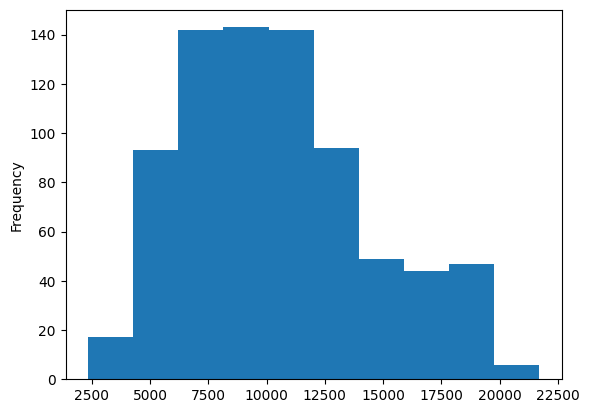

In [7]:
college.Outstate.plot(kind="hist")

In [8]:
college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Private      777 non-null    category
 1   Apps         777 non-null    int64   
 2   Accept       777 non-null    int64   
 3   Enroll       777 non-null    int64   
 4   Top10perc    777 non-null    int64   
 5   Top25perc    777 non-null    int64   
 6   F.Undergrad  777 non-null    int64   
 7   P.Undergrad  777 non-null    int64   
 8   Outstate     777 non-null    int64   
 9   Room.Board   777 non-null    int64   
 10  Books        777 non-null    int64   
 11  Personal     777 non-null    int64   
 12  PhD          777 non-null    int64   
 13  Terminal     777 non-null    int64   
 14  S.F.Ratio    777 non-null    float64 
 15  perc.alumni  777 non-null    int64   
 16  Expend       777 non-null    int64   
 17  Grad.Rate    777 non-null    int64   
dtypes: category(1), float64(1), in

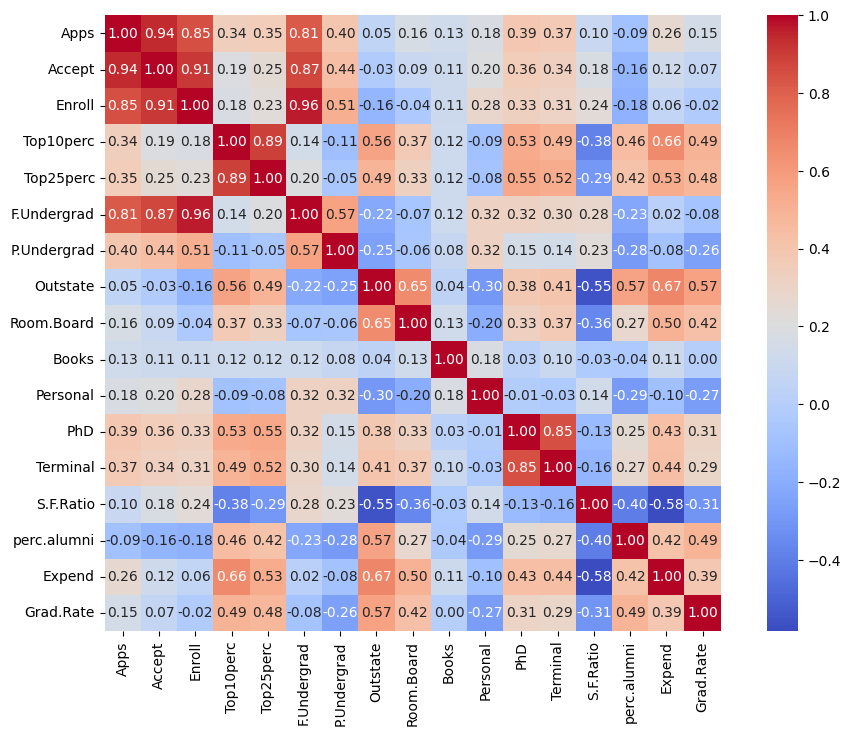

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(college.corr(numeric_only=True),
            annot=True,            # Mostrar números
            fmt=".2f",             # 2. Formato: Solo 2 decimales (float)
            annot_kws={"size": 10}, # 3. Tamaño de la fuente de los números
            cmap="coolwarm",       # (Opcional) Un color map que contraste bien
            square=True,
            ax=ax)           # (Opcional) Forzar a que sean cuadrados perfectos

plt.show()

#### a

In [10]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

Busqueda de los features usando Criterio de akaike

In [56]:
from functools import partial

kfold = skm.KFold(10, shuffle=True, random_state=2)

train, test = skm.train_test_split(college, test_size=.3, random_state=1)

design = MS(college.columns.drop("Outstate")).fit(college)

X_train = design.fit_transform(train)
y_train = train["Outstate"]

X_test = design.transform(test)
y_test = test["Outstate"]

sigma2 = sm.OLS(y_train, X_train).fit().scale
neg_Cp = partial(nCp, sigma2)

strategy = Stepwise.first_peak(design,
                               direction="forward",
                               max_terms=len(design.terms),
                               random_state=1)
selector = sklearn_selected(sm.OLS,
                            strategy,
                            scoring=neg_Cp)
selector.fit(train, y_train)


In [57]:
selector.selected_state_

('Accept',
 'Apps',
 'Enroll',
 'Expend',
 'Grad.Rate',
 'Personal',
 'PhD',
 'Private',
 'Room.Board',
 'S.F.Ratio',
 'Top10perc',
 'Top25perc',
 'perc.alumni')

Bsqueda de los feaurres usando CV

In [58]:

kfold = skm.KFold(10, shuffle=True, random_state=2)

train, test = skm.train_test_split(college, test_size=.3, random_state=1)

design = MS(college.columns.drop("Outstate")).fit(college)

X_train = design.fit_transform(train)
y_train = train["Outstate"]

X_test = design.transform(test)
y_test = test["Outstate"]

strategy = Stepwise.first_peak(design,
                               direction="forward",
                               max_terms=len(design.terms))
selector = sklearn_selected(sm.OLS,
                            strategy,
                            cv=kfold)
selector.fit(train, y_train)


In [66]:
selected_cols = selector.selected_state_

In [25]:
selector.strategy

Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x7e6c3fe47b30>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Room.Board', 'Books', 'Personal', 'PhD',
       'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate'],
      dtype='object'))>, check_finished=<function first_peak at 0x7e6c4bef4180>, postprocess=<function _postprocess_best at 0x7e6c4bef4400>)

In [63]:
# vamos a ver el full path
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction="forward")
full_path = sklearn_selection_path(sm.OLS,
                                  strategy,
                                  cv=kfold)
full_path.fit(train, y_train)


In [64]:
yhat = full_path.predict(test)
yhat.shape

(234, 18)

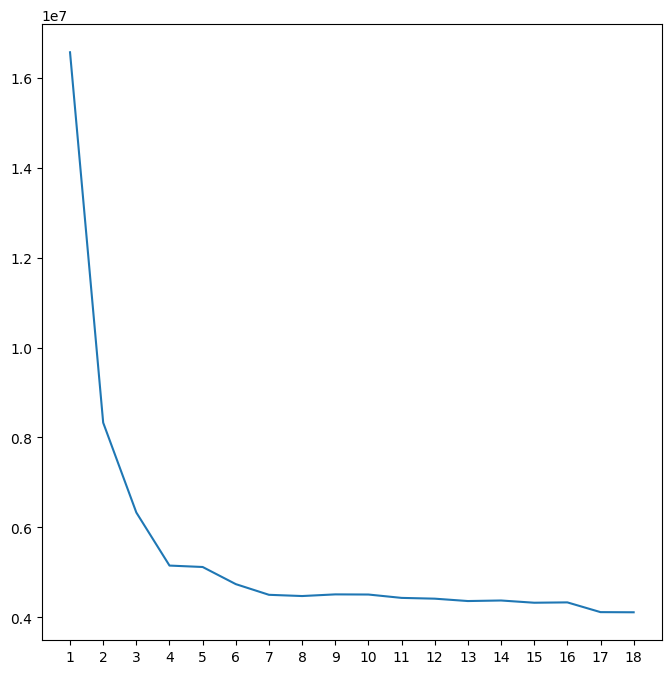

In [65]:
fig, ax = plt.subplots(figsize=(8,8))
sample_mse = np.mean((yhat - y_test.values[:, None])** 2, axis=0)
ax.plot(np.arange(1, len(design.terms)+2 ), sample_mse)
ax.set_xticks(np.arange(1, len(design.terms)+2))

#### b)

ahora vamos a aproximar un modelo GAM con las coluimans encontradas en el proceso de busqueda forward

In [71]:
selected_cols = list(selected_cols)

In [72]:
college[selected_cols]

Expend  Grad.Rate  Personal  PhD Private  Room.Board  Top25perc  \
0      7041         60      2200   70     Yes        3300         52   
1     10527         56      1500   29     Yes        6450         29   
2      8735         54      1165   53     Yes        3750         50   
3     19016         59       875   92     Yes        5450         89   
4     10922         15      1500   76     Yes        4120         44   
..      ...        ...       ...  ...     ...         ...        ...   
772    4469         40      1200   60      No        3900         26   
773    9189         83      1250   73     Yes        4960         47   
774    8323         49       781   67     Yes        4200         61   
775   40386         99      2115   96     Yes        6510         99   
776    4509         99      1250   75     Yes        3560         63   

     perc.alumni  
0             12  
1             16  
2             30  
3             37  
4              2  
..           ...  
772           14  
773           31  
774           20  
775           49  
776           28  

[777 rows x 8 columns]

In [85]:
train.Private = train.Private.cat.codes
test.Private = test.Private.cat.codes

AttributeError: Can only use .cat accessor with a 'category' dtype

In [82]:
gam = LinearGAM(s_gam(0)+
                      s_gam(1)+
                      s_gam(2)+
                      s_gam(3)+
                      f_gam(4, lam=0)+
                      s_gam(5)+
                      s_gam(6)+
                s_gam(7))
gam.fit(train[selected_cols], y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + f(4) + s(5) + s(6) + s(7) + intercept,
   tol=0.0001, verbose=False)

In [89]:
X_test



intercept  Private[Yes]   Apps  Accept  Enroll  Top10perc  Top25perc  \
374        1.0           1.0    594     385     307         36         57   
491        1.0           1.0   1046     824     284         21         45   
678        1.0           0.0   1401    1239     605         10         34   
720        1.0           1.0   5661    2392     903         75         88   
412        1.0           0.0  10634    7064    3176         39         78   
..         ...           ...    ...     ...     ...        ...        ...   
245        1.0           1.0   7178    3755    1433         25         63   
435        1.0           1.0    776     765     351         22         44   
657        1.0           0.0   4418    2737    2049         23         51   
560        1.0           0.0  13528    9198    1843         16         61   
11         1.0           1.0   2652    1900     484         44         77   

     F.Undergrad  P.Undergrad  Room.Board  Books  Personal  PhD  Terminal  \
374         1695          721        2830    600       700   77        79   
491         1223          451        5050    400      1235   64        64   
678         3716          675        4380    540      2948   63        88   
720         3499          172        4360    500      1250   95        97   
412        16505         5481        6540    600      1300   92        98   
..           ...          ...         ...    ...       ...  ...       ...   
245         4623          740        3518    600      2000   60        64   
435         1419          228        3150    500      1900   58        64   
657        14047         5134        3579    450      1700   86        94   
560        10168         1231        4355    700      1560   93        96   
11          1707           44        4440    400       600   73        91   

     S.F.Ratio  perc.alumni  Expend  Grad.Rate  
374       16.5           18    6170         61  
491       19.3           24    7344         69  
678       19.4            0    5389         36  
720        4.3           37   41766         89  
412       17.5           21    9670         62  
..         ...          ...     ...        ...  
245       14.0            9    6791         70  
435       16.2            8    6578         45  
657       22.6            6    5657         35  
560       17.4           16    9075         74  
11         9.9           41   11711         76  

[234 rows x 18 columns]

In [88]:
rmse = np.sqrt(np.mean((y_test - gam.predict(X_test[selected_cols]))**2))
rmse

KeyError: "['Private'] not in index"